# Slabs SCs

In [2]:
import os
import sys

sys.path.append(os.path.abspath(os.path.join(os.getcwd(), '..')))

from Modelos   import *
from FuncsChern import *

import matplotlib.pyplot as plt

plt.rcParams.update({
    'text.usetex':    True,
    'font.family':    'serif',
    'font.serif':     ['Computer Modern'], 
    'axes.unicode_minus': False,
    'text.latex.preamble': r'\usepackage{amsfonts}',
})

plt.rcParams.update({
    "font.size": 18,
    "axes.labelsize": 18,
    "axes.titlesize": 18,
    "xtick.labelsize": 18,
    "ytick.labelsize": 18,
})

def createletters(axs, Axis3D=[], coord=[0.08, 0.92], ni=0, SMALL_SIZE=20):
    import numpy as np
    letters = [r'\textbf{(a)}', r'\textbf{(b)}', r'\textbf{(c)}', r'\textbf{(d)}', r'\textbf{(e)}', r'\textbf{(f)}',
               r'\textbf{(g)}', r'\textbf{(h)}',r'\textbf{(i)}']
    # Aplanar axs si es un array multidimensional
    axs = np.ravel(axs)
    for n, ax in enumerate(axs):
        if n in Axis3D:
            ax.text2D(coord[0], coord[1], letters[max([n, ni])], transform=ax.transAxes, size=SMALL_SIZE, weight='bold')
        else:
            ax.text(coord[0], coord[1], letters[max([n, ni])], transform=ax.transAxes, size=SMALL_SIZE, weight='bold')


Computing ΔE_min(k_z,G)…


G sweep:   0%|          | 0/1201 [00:00<?, ?it/s]

NameError: name 'kz_cross_dict' is not defined

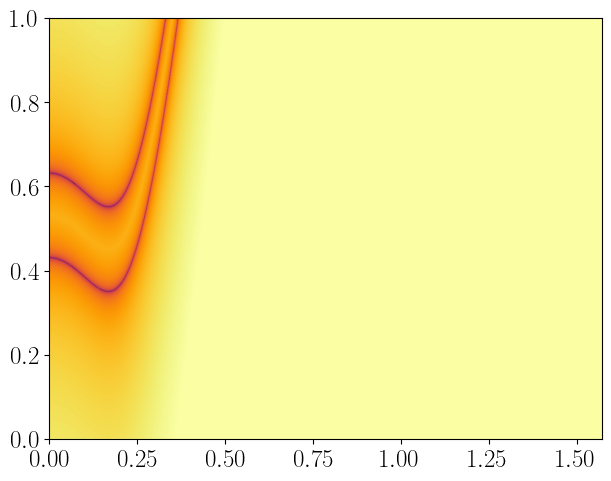

In [2]:
#!/usr/bin/env python3
# -*- coding: utf-8 -*-
"""
gap_and_chern_quartic.py – ΔE_min(k_z,G)  +  |C|(L_z,G) for the SC model.
Refactor & bug-fix 2025-06-05
"""
from __future__ import annotations
import numpy as np
import matplotlib.pyplot as plt
from joblib import Parallel, delayed
from tqdm.auto import tqdm
from matplotlib.colors import BoundaryNorm

# ───────────────────────────────────────────────────────── parameters
MU0, DELTA0  = 0.10, 0.01            # eV
T, M1        = 0.45, 10.0            # eV
c_lat, a_lat = 2.0, 4.0              # Å
NK           = 2                     # k-mesh in kx,ky
G_vals       = np.linspace(0.0, 1.0, 1201)           # eV
kz_vals      = np.linspace(0.0, np.pi/c_lat, 1201)   # Å⁻¹
N_max        = 15                    # up to 15 layers → 30 Å
threshold    = 1e-2                  # eV, “gap ≈ 0”

# ───────────────────────────────────── pre-compute kx,ky dependent grids
kx = np.linspace(0.0, np.pi/a_lat, NK)
ky = np.linspace(0.0, np.pi/a_lat, NK)
kxg, kyg     = np.meshgrid(kx, ky, indexing="ij")
cos_kx, cos_ky = np.cos(kxg * a_lat), np.cos(kyg * a_lat)
sin_kx, sin_ky = np.sin(kxg * a_lat), np.sin(kyg * a_lat)

M_grid_xy = -0.28 + 2*56.6/a_lat**2 * (2.0 - cos_kx - cos_ky)   # (Nk,Nk)
A_grid    =  4.1 / a_lat * np.hypot(sin_kx, sin_ky)             # (Nk,Nk)

# ────────────────────────────────────────── helper: quartic coefficients
def quartic_coeffs_grid(mu: float, G: float, D: float, kz: float) -> np.ndarray:
    eps     = mu
    M1_term = 2*M1 / c_lat**2 * (1.0 - np.cos(kz * c_lat))
    M_grid  = M_grid_xy + M1_term

    D0 = eps**2 + D**2 - M_grid**2 - A_grid**2 - G**2 - T**2
    b0 = 4*G**2 * (M_grid**2 + T**2) - 4*D**2 * (M_grid**2 + A_grid**2)
    b1 = 4*(eps**2 + D**2)

    g0 = -64*G**2*T**2*D**2 * A_grid**2
    g1 =  64*G**2*(eps**2*M_grid**2 + eps**2*T**2 + T**2*D**2)

    a1 = 2*D0 - b1
    a0 = D0**2 - b0

    coeffs = np.stack([np.ones_like(a0),
                       2*a1,
                       a1**2 + 2*a0,
                       2*a0*a1 - g1,
                       a0**2 - g0], axis=-1)
    return coeffs.reshape(-1, 5)      # (Nk*Nk, 5)

# ───────────────────────────────────────── helper: local gap per coeff set
def local_gap_from_coeffs(c: np.ndarray, tol: float = 1e-12) -> float:
    roots = np.roots(c)
    s     = roots.real[np.isreal(roots) & (roots.real > tol)]
    if s.size < 2:            # unphysical / numeric noise
        return np.inf
    E = np.sort(np.concatenate((-np.sqrt(s), np.sqrt(s))))
    return np.abs(E).min()

# ─────────────────────────────────────── ΔE_min(k_z) for a single G
def gap_kz(G: float) -> np.ndarray:
    gaps = np.empty_like(kz_vals)
    for idx, kz in enumerate(kz_vals):
        coeffs = quartic_coeffs_grid(MU0, G, DELTA0, kz)
        # vectorised min over the Nk×Nk coefficients
        local_gaps = np.fromiter((local_gap_from_coeffs(c) for c in coeffs),
                                 dtype=float, count=coeffs.shape[0])
        gmin = local_gaps.min()
        gaps[idx] = gmin
    return gaps                   # (Nkz,)

# ─────────────────────────────────────────ⅰ topological seed at k_z = 0
'''def is_topological_kz0(G: float, mu: float = MU0, D: float = DELTA0) -> bool:
    M0k = -0.28 + 2*56.6/a_lat**2 * 2          # MΓ(kx=ky=0, kz=0)
    f   = (mu**2 + D**2 - M0k**2 - G**2 - T**2)**2 \
          - 4*M0k**2*(G**2 - D**2) - 4*G**2*T**2
    return f < 0'''

# ───────────────────────────────────── Step 1: ΔE_min(k_z, G)
print("Computing ΔE_min(k_z,G)…")
gap_array = Parallel(n_jobs=-1)(
    delayed(gap_kz)(G) for G in tqdm(G_vals, leave=False, desc="G sweep"))
gap_array = np.asarray(gap_array).T   # shape (Nkz, NG)


from scipy import ndimage

chern_map=[]

thr = 2e-2                      # threshold: gap “closed” if Δ < thr
inside = gap_array >= thr         # True → finite gap

labels, n_reg = ndimage.label(
    inside,
    structure=[[0, 1, 0],
               [1, 1, 1],
               [0, 1, 0]]
)




# ─────────────────────────────────────────── FIGURE 1: ΔE_min(k_z, G)
clip_lo, clip_hi = 1e-8, 1e0
log_gap = np.log10(np.clip(gap_array, clip_lo, clip_hi))

fig1, ax1 = plt.subplots(figsize=(6, 4.7), constrained_layout=True)
im = ax1.imshow(log_gap.T, origin='lower',
                extent=[kz_vals[0], kz_vals[-1], G_vals[0], G_vals[-1]],
                aspect='auto', cmap='inferno')

# overlay gap-closing points
for g_idx, kz_list in enumerate(kz_cross_dict):
    G_here = np.full_like(kz_list, G_vals[g_idx])
    ax1.scatter(kz_list, G_here, c='white', s=6, lw=0)

ax1.set(xlabel=r"$k_z$ (Å$^{-1}$)",
        ylabel=r"$G$ (eV)",
        title=r"$\log_{10}\,\Delta E_{\min}(k_z,G)$  –  "
              r"$\Delta=0.01$ eV,  $\tilde\mu=0.10$ eV")
fig1.colorbar(im, ax=ax1, shrink=0.8,
              label=r"$\log_{10}\!\bigl(\Delta E_{\min}\bigr)$ (eV)")
fig1.savefig("gap_G_kz.pdf", dpi=300)

# ─────────────────────────────────────────── FIGURE 2: |C|(L_z, G)
vals_unique = np.sort(np.unique(chern_map))
cmap_disc   = plt.cm.get_cmap('tab20b', len(vals_unique))
bounds      = np.concatenate(([vals_unique[0] - 0.5], vals_unique + 0.5))
norm        = BoundaryNorm(bounds, cmap_disc.N, clip=True)

fig2, ax2 = plt.subplots(figsize=(6.3, 4.7), constrained_layout=True)
im2 = ax2.imshow(chern_map, origin='lower', aspect='auto',
                 extent=[G_vals[0], G_vals[-1], L_vals[0], L_vals[-1]],
                 cmap=cmap_disc, norm=norm)
fig2.colorbar(im2, ax=ax2, boundaries=bounds, ticks=vals_unique,
              spacing='proportional').ax.set_title(r"$|C|$", pad=6)
ax2.set(xlabel=r"$G$ (eV)",
        ylabel=r"$L_z$ (Å)",
        title=r"Multiplicity of Majorana channels")
fig2.savefig("chern_L_G.pdf", dpi=300)

print("Done → gap_G_kz.pdf   and   chern_L_G.pdf")

⏳ 1/3  Calculando ΔE_min(kz,G)…


G sweep:   0%|          | 0/1201 [00:00<?, ?it/s]

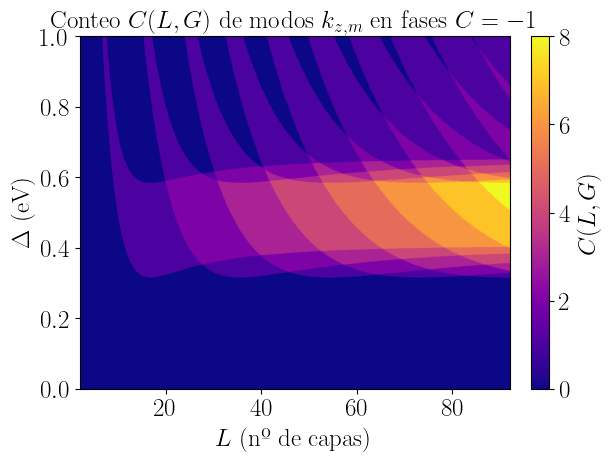

In [3]:
#!/usr/bin/env python3
# -*- coding: utf-8 -*-
"""
C(L,G) map – count of kz‐quantised modes that fall in topological windows
"""

import numpy as np
import matplotlib.pyplot as plt
from scipy import ndimage
from joblib import Parallel, delayed
from tqdm.auto import tqdm

# ─────────────────────────── 1. MODELO Y PARRILLA ────────────────────
MU0, DELTA0      = 0.10, 0.1            # eV
T, M1            = 0.45, 10.0            # eV
c_lat, a_lat     = 2.0, 4.0              # Å
NK               = 2                     # kx-ky malla
G_vals           = np.linspace(0.0, 1.0, 1201)           # eV
kz_vals          = np.linspace(0.0, np.pi/c_lat, 1201)   # Å⁻¹
N_max            = 45                    # hasta 15 capas
thr_gap          = 7e-3                  # eV → gap “cerrado” si Δ < thr

# k-mesh (kx,ky)
kx = np.linspace(0.0, np.pi/a_lat, NK)
ky = np.linspace(0.0, np.pi/a_lat, NK)
kxg, kyg = np.meshgrid(kx, ky, indexing="ij")
cos_kx, cos_ky = np.cos(kxg*a_lat), np.cos(kyg*a_lat)
sin_kx, sin_ky = np.sin(kxg*a_lat), np.sin(kyg*a_lat)

M_grid_xy = -0.28 + 2*56.6/a_lat**2 * (2.0 - cos_kx - cos_ky)
A_grid    =  4.1 / a_lat * np.hypot(sin_kx, sin_ky)

# ─────────  helper 1: coeficientes del cuártico en (kx,ky) → ΔEmin(kz) ─
def quartic_coeffs(mu, G, D, kz):
    eps     = mu
    M1_term = 2*M1 / c_lat**2 * (1 - np.cos(kz * c_lat))
    M_grid  = M_grid_xy + M1_term

    D0 = eps**2 + D**2 - M_grid**2 - A_grid**2 - G**2 - T**2
    b0 = 4*G**2*(M_grid**2 + T**2) - 4*D**2*(M_grid**2 + A_grid**2)
    b1 = 4*(eps**2 + D**2)

    g0 = -64*G**2*T**2*D**2 * A_grid**2
    g1 =  64*G**2*(eps**2*M_grid**2 + eps**2*T**2 + T**2*D**2)

    a1 = 2*D0 - b1
    a0 = D0**2 - b0

    coeffs = np.stack([np.ones_like(a0),
                       2*a1,
                       a1**2 + 2*a0,
                       2*a0*a1 - g1,
                       a0**2 - g0], axis=-1)
    return coeffs.reshape(-1, 5)

def local_gap_from_coeffs(c, tol=1e-12):
    roots = np.roots(c)
    s     = roots.real[np.isreal(roots) & (roots.real > tol)]
    if s.size < 2:
        return np.inf
    E = np.sort(np.concatenate((-np.sqrt(s), np.sqrt(s))))
    return np.abs(E).min()

def gap_vs_kz(G):
    gaps = np.empty_like(kz_vals)
    for i, kz in enumerate(kz_vals):
        coeff = quartic_coeffs(MU0, G, DELTA0, kz)
        local = np.fromiter((local_gap_from_coeffs(c) for c in coeff),
                            dtype=float, count=coeff.shape[0])
        gaps[i] = local.min()
    return gaps

print("⏳ 1/3  Calculando ΔE_min(kz,G)…")
gap_array = Parallel(n_jobs=-1)(
    delayed(gap_vs_kz)(G) for G in tqdm(G_vals, desc="G sweep", leave=False))
gap_array = np.asarray(gap_array).T      # (Nkz, NG)

# ────────────────────── 2. CLASIFICAR C=0, C=-1, NaN ──────────────────
finite_gap = gap_array >= thr_gap            # True = gap abierto
labels, n_reg = ndimage.label(
    finite_gap,
    structure=[[0,1,0],[1,1,1],[0,1,0]]
)

phase_dict = {1: ( 0, "tab:red"),
              2: (-1, "tab:blue"),
              3: ( 0, "white")}            # ajusta si aparecen más regiones

code_map = np.full_like(labels, np.nan, dtype=float)
for lab, (code, _) in phase_dict.items():
    code_map[labels == lab] = code
code_phases = code_map                     # (Nkz, NG)

# ────────────────────── 3. INTERVALOS TOPO (C=-1) POR G ───────────────
topo_intervals = []
for col in code_phases.T:                 # recorre G
    idx = np.where(col == -1)[0]
    if idx.size == 0:
        topo_intervals.append([])
        continue
    # agrupa en trozos contiguos
    splits = np.split(idx, np.where(np.diff(idx) > 1)[0]+1)
    intervals = [(kz_vals[s[0]], kz_vals[s[-1]]) for s in splits]
    topo_intervals.append(intervals)      # lista de (kz_ini, kz_fin)
topo_intervals = np.asarray(topo_intervals, dtype=object)  # shape (NG,)

# ────────────────────── 4. MAPA  C(L,G)  ──────────────────────────────
L_vals = np.linspace(1, N_max+1,1000)             # 1…N_max
C_map  = np.zeros((L_vals.size, G_vals.size), dtype=int)

for iL, L in enumerate(L_vals):
    kz_modes = ((np.arange(L)+1) * np.pi) / ((L+1) * c_lat)   # (L,)
    for iG, intervals in enumerate(topo_intervals):
        if not intervals:   # no zona topológica en este G
            continue
        count = 0
        for kz in kz_modes:
            # comprueba si kz cae dentro de algún intervalo
            if any(lo - 1e-12 <= kz <= hi + 1e-12 for lo, hi in intervals):
                count += 1
        C_map[iL, iG] = count

# ────────────────────── 5. PLOT  C(L,G) ───────────────────────────────
fig, ax = plt.subplots(figsize=(6,4.5), constrained_layout=True)
im = ax.imshow(C_map.T, origin='lower',
               extent=[L_vals[0]*c_lat, L_vals[-1]*c_lat,
                       G_vals[0], G_vals[-1]],
               aspect='auto', cmap='plasma')

ax.set_xlabel(r'$L$  (nº de capas)')
ax.set_ylabel(r'$\Delta$  (eV)')
ax.set_title(r'Conteo $C(L,G)$ de modos $k_{z,m}$ en fases $C=-1$')
fig.colorbar(im, ax=ax, label=r'$C(L,G)$')
plt.show()

/var/folders/tv/w7tvz05d1j781wvdwyk3sq100000gn/T/ipykernel_2156/1384602774.py:50: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cmap_d    = plt.cm.get_cmap("tab20b", len(vals))


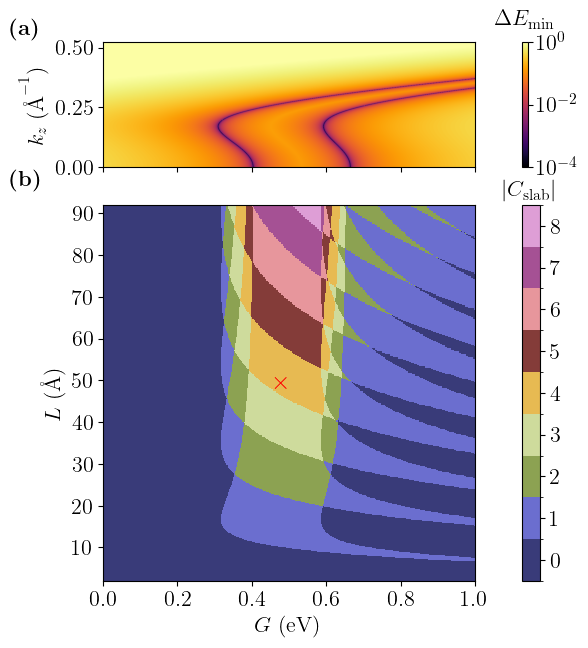

In [36]:
# ───────────────────────── 2. PLOTS (Δmin  y  |C(L,G)|) ─────────────────────────
import matplotlib.pyplot as plt
from matplotlib.colors import LogNorm, BoundaryNorm
import numpy as np

# 1) Ajustes de estilo global
plt.rcParams.update({
    "font.size":      16,
    "axes.labelsize": 16,
    "axes.titlesize": 16,
    "xtick.labelsize":16,
    "ytick.labelsize":16,
})

# 2) Figura con dos filas (más juntas) ───────────────────────────────────────────
fig, (ax1, ax2) = plt.subplots(
    2, 1, figsize=(6, 7),
    sharex=True,
    gridspec_kw={
        "height_ratios": [1, 3],   # fila-1 más baja
        "hspace": 0.15             # ← menos espacio vertical
    }
)

# ─────── (a) Mapa del gap mínimo  Δmin(kz,G) ───────
im1 = ax1.imshow(
    gap_array[:400, :],                 # filas = G, columnas = kz
    origin="lower",
    extent=[G_vals[0], G_vals[-1], kz_vals[0], kz_vals[400]],
    aspect="auto",
    cmap="inferno",
    norm=LogNorm(vmin=1e-4, vmax=1.0)
)

# Etiquetas Y específicas
ax1.set_yticks([0, 0.25, 0.5])
ax1.set_ylabel(r"$k_z \;(\mathrm{\AA}^{-1})$")

# Colorbar más ancha
cbar1 = fig.colorbar(
    im1, ax=ax1,
    fraction=0.1,    # ancho relativo (↑ → más ancho)
    pad=0.1         # separación al eje
)
cbar1.ax.set_title(r"$\Delta E_{\mathrm{min}}$", pad=12)

# ─────── (b) Fases topológicas  |C(L,G)| ───────
chern_map = np.abs(C_map)
vals      = np.sort(np.unique(chern_map))
cmap_d    = plt.cm.get_cmap("tab20b", len(vals))
bounds    = np.concatenate(([vals[0]-0.5], vals+0.5))
norm      = BoundaryNorm(bounds, cmap_d.N, clip=True)

im2 = ax2.imshow(
    chern_map, origin="lower",
    extent=[G_vals[0], G_vals[-1],
            L_vals[0]*c_lat, L_vals[-1]*c_lat],
    aspect="auto", interpolation="none",
    cmap=cmap_d, norm=norm
)

# Colorbar de |C| (anchura estándar)
cbar2 = fig.colorbar(
    im2, ax=ax2, boundaries=bounds,
    ticks=vals, spacing="proportional",fraction=0.1,    # ancho relativo (↑ → más ancho)
    pad=0.1 
)
cbar2.ax.set_title(r"$|C_\mathrm{slab}|$", pad=6)

# Etiquetas ejes
ax2.set_xlabel(r"$G$ (eV)")
ax2.set_ylabel(r"$L$ (Å)")

# Etiquetas Y del segundo plot: 0 → 90 en pasos de 10
ax2.set_yticks(np.arange(10, 91, 10))

# Punto guía (rojo) como referencia
ax2.text(
    0.46, 50.0, r'$\times$',
    va='center', ha='left',
    c='r', fontsize=18, fontweight='bold'
)

# Letras de paneles
createletters((ax1, ax2), coord=[-0.25, 1.05], SMALL_SIZE=16)

plt.savefig('Figs/SecIV/SlabsKZCHern.svg', bbox_inches='tight')
plt.show()

In [20]:
cmap_reused=cmap_d

## Finite System

In [27]:
import sys

sys.path.append('..')

from FuncsChern import *
import numpy as np
import kwant

# Pauli matrices
sx = np.array([[0, 1],[1, 0]], dtype=complex)
sy = np.array([[0, -1j],[1j, 0]], dtype=complex)
sz = np.array([[1, 0],[0, -1]], dtype=complex)
s0 = np.eye(2, dtype=complex)

def sorted_eigs(ev):
    """ Function to sort the eigenvecs according to the eigenvalue order """ 
    evals, evecs = ev
    order = np.argsort(evals)
    return np.array(evals[order]), np.array(evecs[:, order])

from tqdm import tqdm  # Importar tqdm para la barra de progreso
import scipy.sparse.linalg as sla

def kron3(A, B, C):
    return np.kron(np.kron(A, B), C)

def Matrices_Gamma():

    Gz00 = kron3(sz,s0,s0)
    Gz0z = kron3(sz,s0,sz)
    G00x = kron3(s0,s0,sx)
    Gzzy = kron3(sz,sz,sy)
    Gzzz = kron3(sz,sz,sz)
    G0yy = kron3(s0,sy,sy)
    Gyyz = kron3(sy,sy,sz)
    Gxyz = kron3(sx,sy,sz)
    Gzyy = kron3(sz,sy,sy)
    Gzxx = kron3(sz,sx,sx)

    return Gz00, Gz0z, G00x, Gzzy, Gzzz, G0yy, Gyyz, Gzyy, Gxyz, Gzxx

Gz00, Gz0z, G00x, Gzzy, Gzzz, G0yy, Gyyz, Gzyy, Gxyz, Gzxx = Matrices_Gamma()


def Slab_BHZ_SC_kzky(params):
    a   = params["a"]
    c   = params["c"]
    L_y = params["L_y"]  
    L_z = params["L_z"]  

    ##Tengo que cambiar esto  ¿?
    ## No estoy de acuerdo con tener que cambiar c, c es el periodo con el que se repite la celda. 

    lat = kwant.lattice.general([(a, 0), (0, c)], basis=[(0, 0)], norbs=8)

    def onsite(site, kx, a,c, C0, C1, C2, M0, M1, M2, A, G, Delta,T,B):
            z = int(site.tag[1])
            ck2_xy = 2.0 - np.cos(kx * a)
            ck2_z = 1
            epsilon_0 = C0 + (2 * C2 / (a ** 2)) * ck2_xy + (2 * C1 / (c ** 2)) * ck2_z
            M_0 = M0 + (2 * M2 / (a ** 2)) * ck2_xy + (2 * M1 / (c ** 2))* ck2_z
            
            OS_matrix = (
                epsilon_0 * Gz00 +
                (A/a) * (np.sin(kx * a) * G00x) +
                M_0 * Gz0z +
                G * Gzzz +
                Delta * Gyyz+ T*Gzyy)
            return OS_matrix

    # Hopping en dirección z
    def hopping_z(site1, site2, c, C1, M1, B,T):
        #z = int(site1.tag[1])
        return (C1 / c**2) * Gz00 + (M1 / c**2) * Gz0z + (1j * B / (2 * c) * G0yy)

    # Hopping en dirección y
    def hopping_y(site1, site2, a, C2, M2, A):

        return (C2 / a**2) * Gz00 + (M2 / a**2) * Gz0z + (1j * A) / (2 * a) * Gzzy

    syst = kwant.Builder()

    
    def shape(pos):
        y, z = pos 
        return (0 <= y < L_y) and (0 <= z < L_z)

    
    syst[lat.shape(shape, (0, 0))] = onsite

    # Hoppings en la dirección y
    syst[kwant.builder.HoppingKind((1, 0), lat.sublattices[0], lat.sublattices[0])] = hopping_y
    #syst[kwant.builder.HoppingKind((-1, 0), lat.sublattices[0], lat.sublattices[0])] = (
    #    lambda s1, s2, a, C2, M2, A: np.conjugate(hopping_y(s2, s1, a, C2, M2, A).T)
    #)

    # Hoppings en la dirección z
    syst[kwant.builder.HoppingKind((0, 1), lat.sublattices[0], lat.sublattices[0])] = hopping_z
    #syst[kwant.builder.HoppingKind((0, -1), lat.sublattices[0], lat.sublattices[0])] = (
    #    lambda s1, s2, c, C1, M1, B: np.conjugate(hopping_z(s2, s1, c, C1, M1, B).T)
    #)

    return syst.finalized()

In [28]:
def M0_func(z, L_z, M0vec):
    if z<1/2*L_z:
        return M0vec[0]
    else:
        if z<L_z:
            return M0vec[1]
        else:
            return M0vec[2]


def Delta_func(z, alpha, Delta,L,c):
    return np.abs(Delta * (1-alpha*z/(L)))*np.exp(1j*np.angle(Delta)) 

def Delta_func2(z, alpha, Delta,L,c):
    return np.abs(Delta * (alpha*z/(L)))*np.exp(1j*np.angle(Delta)) 

def G_func(z, L_z, Gvec):
    if z<1/2*L_z:
        return Gvec[0]
    else:
        if z<L_z:
            return Gvec[1]
        else:
            return Gvec[2]
        
def T_func(z, L_z, Tvec):
    if z<1/2*L_z:
        return Tvec[0]
    else:
        if z<L_z:
            return Tvec[1]
        else:
            return Tvec[2]

def B_func(z, L_z, Bvec):
    if z<1/2*L_z:
        return Bvec[0]
    else:
        if z<L_z:
            return Bvec[1]
        else:
            return Bvec[2]

#c=28.64
#a=4.14

## Una QL son 10A, que son : Se-Bi-Se-Bi-Se. La c son aproximadamente 3 QLs

H_params = {
        "L_z":10 * 5 , ## 10 * QLs * SLABS
        "L_y":300,
        "C0":0.1, ## mu=56.3 meV [+ electrones, - huecos]
        "C2": 0,
        "C1": 0,
        "M0":-0.28, ## 0.28 eV
        "G":-0.46,
        "M1": 10,
        "M2": 56.59,
        "A" : 4.1,
        "B" : 0,  
        "T":0.45,
        "Delta": 0.1, ## 100 meV
        "a" : 4, ## 4  A
        "c":  2, ## Longitud QL / Nsitios
        "ky":0,
        "B":0,
        "kz":0
            }

syst = Slab_BHZ_SC_kzky(H_params)

In [29]:
def sorted_eigs(ev):
    """ Function to sort the eigenvecs according to the eigenvalue order """ 
    evals, evecs = ev
    order = np.argsort(evals)
    return np.array(evals[order]), np.array(evecs[:, order])

from tqdm import tqdm  # Importar tqdm para la barra de progreso
import scipy.sparse.linalg as sla
import scipy.sparse as ss




a= H_params["a"]
c= H_params["c"]

Ly = H_params["L_y"]
Lz = H_params["L_z"]

Ly = int(Ly/a)
Lz = int(Lz/c)


print([Ly,Lz])

N_k      = 31
bands   = 20
kx_values = np.linspace(-0.05, 0.05, N_k)

energy_kx = []
eigenvectors_kx = []
previous_evecs = None

for ki in tqdm(kx_values, desc="Calculando Autovalores/Autovectores", unit="k-point"):
    H_params["kx"] = ki
    H_k = syst.hamiltonian_submatrix(params=H_params, sparse=True)


    ens, wfs = sla.eigsh(H_k.tocsc(), k=bands, sigma=0, return_eigenvectors=True)
    ens, wfs = sorted_eigs([ens, wfs])
    
    energy_kx.append(ens)
    eigenvectors_kx.append(wfs)



energy_kx = np.array(energy_kx)
eigenvectors_kx = np.array(eigenvectors_kx)
eigenvectors_kx = eigenvectors_kx.reshape([N_k, 8*Ly*Lz, bands])

[75, 25]


Calculando Autovalores/Autovectores: 100%|██████████| 31/31 [02:42<00:00,  5.25s/k-point]


In [30]:
Q_mat = np.kron(np.eye(Ly*Lz), kron3(sz, s0, s0))

# ---------- cálculos ----------
Nk, Nb = energy_kx.shape
Q_expect = np.empty((Nk, Nb))

Q_expect = np.einsum(
    'kan,ac,kcn->kn',                # índices: k a n · a c · k c n → k n
    np.conj(eigenvectors_kx),        # (Nk, 4L, Nb)  → k a n
    Q_mat,                           # (4L, 4L)      → a c
    eigenvectors_kx,                 # (Nk, 4L, Nb)  → k c n
    optimize=True                    # deja que NumPy elija la ruta óptima
).real 

Los 30 valores más pequeños (en valor absoluto) para k_x=0.003333333333333334:
1. Banda: 9, Energía: -0.0067250411487527325
2. Banda: 10, Energía: 0.006725041148752916
3. Banda: 8, Energía: -0.006744416075399653
4. Banda: 11, Energía: 0.006744416075399904
5. Banda: 7, Energía: -0.007268661164677427
6. Banda: 12, Energía: 0.007268661164677614
7. Banda: 13, Energía: 0.008079705167737362
8. Banda: 6, Energía: -0.008079705167737438
9. Banda: 14, Energía: 0.05164948635668899
10. Banda: 5, Energía: -0.05164948635668919
11. Banda: 4, Energía: -0.07144588288945962
12. Banda: 15, Energía: 0.07144588288945974
13. Banda: 3, Energía: -0.07876346643219488
14. Banda: 16, Energía: 0.07876346643219494
15. Banda: 2, Energía: -0.0833903119870894
16. Banda: 17, Energía: 0.08339031198709003
17. Banda: 18, Energía: 0.09756770182297396
18. Banda: 1, Energía: -0.09756770182297443
19. Banda: 19, Energía: 0.10387386037817073
20. Banda: 0, Energía: -0.10387386037817088


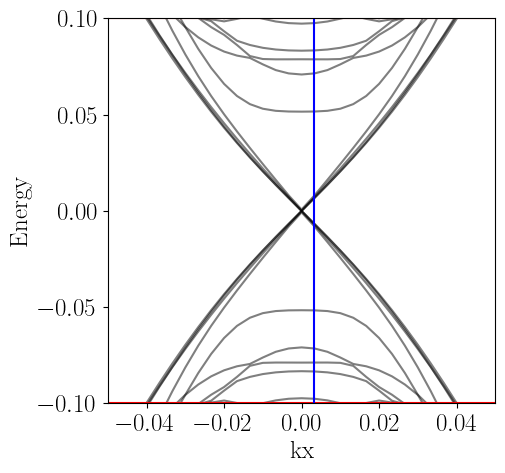

In [31]:
fig, axs = plt.subplots(1, 1, figsize=(5, 5)) 
# Plotear las bandas
Emin=-0.1
Emax=0.1
for j in range(energy_kx.shape[1]):
    axs.plot(kx_values, energy_kx[:, j], alpha=0.5,c='k')
plt.axhline(Emin,c='r')
plt.axhline(Emax,c='r')


## Sacar los minimos: 

kx_selected_index = N_k//2+1
plt.axvline(kx_values[kx_selected_index],c='b')

num_minima = 30

energies_for_kx = energy_kx[kx_selected_index, :]

sorted_indices = np.argsort(np.abs(energies_for_kx))[:num_minima]

min_values = [(band_idx, energies_for_kx[band_idx]) for band_idx in sorted_indices]

plt.ylim([Emin,Emax])
plt.xlim([kx_values[0],kx_values[-1]])

plt.xlabel('kx')
plt.ylabel('Energy')

plt.savefig('dispersionCercaTIB.pdf',dpi=300, bbox_inches='tight')


print(f"Los {num_minima} valores más pequeños (en valor absoluto) para k_x={kx_values[kx_selected_index]}:")
for i, (band_idx, energy) in enumerate(min_values):
    print(f"{i+1}. Banda: {band_idx}, Energía: {energy}")

In [41]:
pos_idx

array([1, 3, 5, 6])

/var/folders/tv/w7tvz05d1j781wvdwyk3sq100000gn/T/ipykernel_94262/131144183.py:121: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


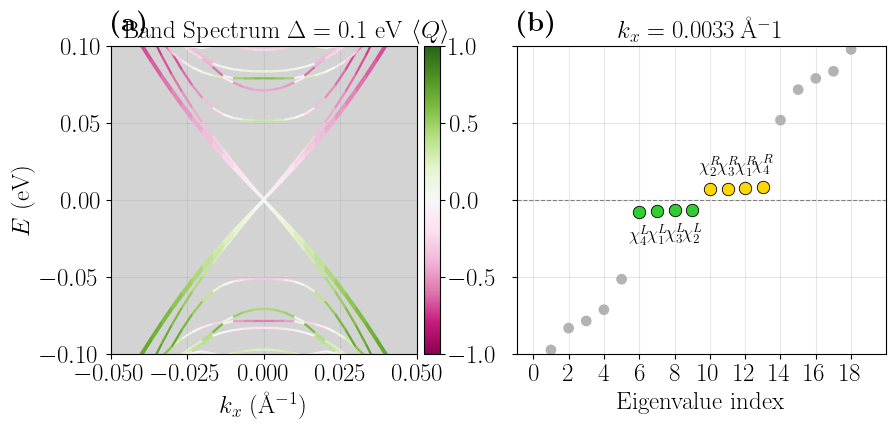

In [55]:
# ──────────────────────────────────────────────────────────────────────
# 3) FIGURA 1×2 :  panel de bandas              +      espectro puntual
# ──────────────────────────────────────────────────────────────────────
fig, (ax_band, ax_spec) = plt.subplots(
    1, 2, figsize=(10, 4), sharey=True,
    gridspec_kw=dict(wspace=0.10)
)

# ─────────────────────── 3a) Bandas E(kx) ────────────────────────────
from matplotlib.collections import LineCollection

# rango de energía que queremos mostrar
Emin, Emax = -0.10, 0.10

cmap = plt.cm.PiYG               # gradiente verde-magenta
norm = plt.Normalize(vmin=-1, vmax=1)

for j in range(Nb):
    x = kx_values                # (Nk,)
    y = energy_kx[:, j]          # (Nk,)
    q = Q_expect[:, j]           # (Nk,)

    # 1) segmentos (x_i,y_i) → (x_{i+1},y_{i+1})
    pts      = np.column_stack([x, y]).reshape(-1, 1, 2)
    segments = np.concatenate([pts[:-1], pts[1:]], axis=1)   # (Nk-1,2,2)

    # 2) color = media de <Q> en los extremos
    q_seg = 0.5 * (q[:-1] + q[1:])

    # 3) añade colección al eje
    lc = LineCollection(segments, cmap=cmap, norm=norm, linewidths=1.6)
    lc.set_array(q_seg)
    ax_band.add_collection(lc)

# barra de color
sm = plt.cm.ScalarMappable(cmap=cmap, norm=norm)
sm.set_array([])
cbar = plt.colorbar(sm, ax=ax_band, pad=0.02)
cbar.ax.set_title(r'$\langle Q\rangle$')

# ajustes de eje
ax_band.set_xlim(kx_values[0], kx_values[-1])
ax_band.set_ylim(Emin, Emax)
ax_band.set_xlabel(r'$k_x$ (\AA$^{-1}$)')
ax_band.set_ylabel(r'$E$ (eV)')
ax_band.set_title(r'Band Spectrum $\Delta = 0.1$ eV')
ax_band.set_facecolor('lightgrey')
ax_band.grid(alpha=0.4)

# ─────────────────────── 3b) Espectro puntual ────────────────────────
# 1) espectro completo (puntos base)
energies     = energy_kx[k_idx]
sort_idx     = np.argsort(energies)
energies_ord = energies[sort_idx]

# ventana de ±20 niveles alrededor de E≈0
i0 = np.argmin(np.abs(energies_ord))
lo, hi = max(i0 - 20, 0), min(i0 + 20, len(energies_ord))

x_vals = np.arange(lo, hi)
E_vals = energies_ord[lo:hi]

thr = 0.05                           # umbral para colorear
base_colors = ['tab:red'   if  0 < E <=  thr else
               'tab:blue'  if -thr <= E <  0 else
               '0.7' for E in E_vals]

ax_spec.scatter(x_vals, E_vals, s=45, c=base_colors, zorder=1)
ax_spec.axhline(0, ls='--', lw=0.8, color='grey')

# 2) estados seleccionados (|E| más pequeños) -------------------------
m_order = [2, 3, 1, 4]          # orden de los índices m

# separamos positivos y negativos con la energía y el índice ordenado
sel_pos = [(band, E) for band, E in zip(idx_sel, E_sel) if E > 0]
sel_neg = [(band, E) for band, E in zip(idx_sel, E_sel) if E < 0]

# ordenados por |E| creciente
sel_pos.sort(key=lambda t: t[1])          # t = (band,E)
sel_neg.sort(key=lambda t: abs(t[1]))

def highlight(selection, color, label_side, text_offset):
    """
    Dibuja y etiqueta una lista de estados seleccionados.

    selection  : lista de (band_idx, E)
    color      : 'gold' o 'limegreen'
    label_side : r'^{R}' o r'^{L}'
    text_offset: desplazamiento vertical del texto
    """
    for rank, (band_idx, E) in enumerate(selection):
        # posición x del punto dentro de la ventana lo-hi
        where = np.where(sort_idx[lo:hi] == band_idx)[0]
        if not len(where):          # si ese estado quedó fuera de la ventana
            continue
        x = x_vals[where[0]]

        # punto destacado
        ax_spec.scatter(x, E, s=80, color=color,
                        edgecolor='k', linewidth=0.6, zorder=4)

        # etiqueta desplazada
        m = m_order[rank]
        ax_spec.text(x, E + text_offset,
                     fr'$\chi_{{{m}}}{label_side}$',
                     ha='center', va='center',
                     fontsize=13, zorder=5)

# positivos → amarillo, texto un poco *arriba*
# negativos → verde,    texto un poco *abajo*
highlight(sel_pos, 'gold',      r'^{R}', +0.015)
highlight(sel_neg, 'limegreen', r'^{L}', -0.015)

# 3) ajustes finales del sub-gráfico ---------------------------------
ax_spec.set_xlabel(r'Eigenvalue index')
ax_spec.set_title(fr'$k_x = {kx_values[k_idx]:.4f}\,$\AA$^{-1}$')
ax_spec.set_xticks(x_vals[::2])
ax_spec.grid(alpha=0.3)

# ───────────────────────── 4) SALIDA ────────────────────────────────
plt.tight_layout()
createletters((ax_band, ax_spec), coord=[0, 1.05])
plt.savefig('Figs/SecIV/BandsDelta01.svg', bbox_inches='tight')
plt.show()

In [ ]:
### 1) SELECCIÓN DE LOS 8 PRIMEROS ESTADOS (|E| más pequeños)
k_idx      = N_k // 2 + 1                      # k fijo (≈ centro)
energies_k = energy_kx[k_idx, :]

idx_sel    = np.argsort(np.abs(energies_k))[:8]   # ← ¡ahora son 8!
E_sel      = energies_k[idx_sel]

print("Índices y energías seleccionadas en k={}:".format(k_idx))
for i, (n, E) in enumerate(zip(idx_sel, E_sel), 1):
    print(f"  {i:2d}) banda {n:3d} : E = {E: .5f} eV")


L=Ly*Lz
### 2) POLARIZACIÓN DE MAJORANA PARA CADA ESTADO
C_mat  = np.kron(np.eye(L), kron3(sx, s0, s0))
chis   = []                                     # χ_i para i=1,…,8

for n in idx_sel:
    u = eigenvectors_kx[k_idx, :, n]            # (4L,)
    chi = np.abs(np.vdot(np.conj(u), C_mat @ np.conj(u)))**2
    chis.append(chi)

chis = np.array(chis)

### 3) FIGURA 1×2 (panel de bandas + espectro puntual) -------------
fig, (ax_band, ax_spec) = plt.subplots(
    1, 2, figsize=(10, 4), sharey=True,
    gridspec_kw=dict(wspace=0.10)
)

# -------- 3a) Bandas E(kx) + etiquetas ξ_i (E > 0) ----------------
from matplotlib.collections import LineCollection

Emin, Emax = -0.1, 0.1
cmap = plt.cm.PiYG
norm = plt.Normalize(vmin=-1, vmax=1)

for j in range(Nb):
    x = kx_values                      # (Nk,)
    y = energy_kx[:, j]                # (Nk,)
    q = Q_expect[:, j]                 # (Nk,)

    # 1) construye pares de puntos (x_i,y_i) → (x_{i+1},y_{i+1})
    pts      = np.column_stack([x, y]).reshape(-1, 1, 2)
    segments = np.concatenate([pts[:-1], pts[1:]], axis=1)   # (Nk-1, 2, 2)

    # 2) color de cada segmento = media de q_i y q_{i+1}
    q_seg = 0.5 * (q[:-1] + q[1:])      # (Nk-1,)

    # 3) crea la colección y añádela al eje
    lc = LineCollection(segments, cmap=cmap, norm=norm,
                        linewidths=1.6)
    lc.set_array(q_seg)
    ax_band.add_collection(lc)

# barra de color
sm = plt.cm.ScalarMappable(cmap=cmap, norm=norm)
sm.set_array([])
cbar = plt.colorbar(sm, ax=ax_band, pad=0.02)
cbar.set_label(r'$\langle Q\rangle$')

# ejes y límites como antes
Emin, Emax = -0.1, 0.1
ax_band.set_facecolor('lightgrey')

# → Etiqueta solo los 4 niveles con energía positiva
#    (entre los 8 de |E| más pequeño)
pos_idx   = np.where(E_sel > 0)[0]
# ordena ascendentemente por energía
pos_order = pos_idx[np.argsort(E_sel[pos_idx])]

y_pos=np.linspace(0.02,0.08,4)

for nn, idx in enumerate(pos_order, start=1):
    E = y_pos[nn-1]
    ax_spec.text(pos_order, E,
                 fr'$\chi_{{{nn}}}$',
                 fontsize=14, ha='center', va='center',
                 zorder=5)

ax_band.set_xlim(kx_values[0], kx_values[-1])
ax_band.set_ylim(Emin, Emax)
ax_band.set_xlabel(r'$k_x$ (\AA$^{-1}$)')
ax_band.set_ylabel(r'$E$ (eV)')
ax_band.set_title(r'Band Spectrum $\Delta=0.1$ eV')
ax_band.grid()

# -------- 3b) Espectro puntual (tal cual estaba) ------------------
#  (copiado sin cambios)
kx_idx   = k_idx               # usa la misma k fija
energies = energy_kx[kx_idx]
sort_idx = np.argsort(energies)
energies_sorted = energies[sort_idx]

i0  = np.argmin(np.abs(energies_sorted))
lo  = max(i0 - 20, 0)
hi  = min(i0 + 20, len(energies_sorted))
n_sel = np.arange(lo, hi)
E_sel_spec = energies_sorted[lo:hi]

threshold = 0.05
colors = ['tab:red'  if 0 < E <= threshold else
          'tab:blue' if -threshold <= E < 0 else
          '0.7' for E in E_sel_spec]

ax_spec.scatter(n_sel, E_sel_spec, s=45, c=colors, zorder=3)
ax_spec.axhline(0, ls='--', lw=0.8, color='grey')
ax_spec.set_xlabel(r'\# Eigenvalue')
ax_spec.set_title(fr'$k_x = {kx_values[kx_idx]:.4f}$ \AA$^{{-1}}$')
ax_spec.set_xticks(n_sel[::2])
ax_spec.tick_params(axis='x', rotation=0)
ax_spec.grid(alpha=0.3)

# -------- 4) SALIDA ----------------------------------------------
plt.tight_layout()
createletters((ax_band, ax_spec), coord=[0, 1.05])
plt.savefig('Figs/SecIV/BandsDelta01.pdf', bbox_inches='tight')
plt.show()

Índices y energías seleccionadas en k=16:
   1) banda   9 : E = -0.00673 eV
   2) banda  10 : E =  0.00673 eV
   3) banda   8 : E = -0.00674 eV
   4) banda  11 : E =  0.00674 eV
   5) banda   7 : E = -0.00727 eV
   6) banda  12 : E =  0.00727 eV
   7) banda  13 : E =  0.00808 eV
   8) banda   6 : E = -0.00808 eV


/var/folders/tv/w7tvz05d1j781wvdwyk3sq100000gn/T/ipykernel_94262/1569144716.py:115: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


TypeError: only length-1 arrays can be converted to Python scalars

Error in callback <function _draw_all_if_interactive at 0x121c3bba0> (for post_execute), with arguments args (),kwargs {}:


TypeError: only length-1 arrays can be converted to Python scalars

TypeError: only length-1 arrays can be converted to Python scalars

<Figure size 1000x400 with 3 Axes>

kx selected: 0.003333333333333334
Lx, Lz (number of sites): [75, 25]


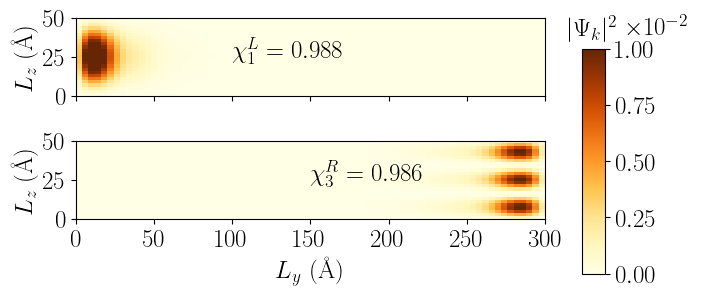

In [66]:
from matplotlib.lines import Line2D
from matplotlib.colors import Normalize
from matplotlib.cm import ScalarMappable
from matplotlib.ticker import FuncFormatter
import matplotlib.pyplot as plt

kx_selected_index = N_k//2+1

num_minima = 30

energies_for_kx = energy_kx[kx_selected_index, :]

sorted_indices = np.argsort(np.abs(energies_for_kx))[:num_minima]

min_values = [(band_idx, energies_for_kx[band_idx]) for band_idx in sorted_indices]

nbands = sorted_indices  


state0 = 4
state1 = 3
ki = [N_k // 2 + 1]
print("kx selected:", kx_values[ki[0]])

a = H_params["a"]
c = H_params["c"]

Ly = int(H_params["L_y"] / a)
Lz = int(H_params["L_z"] / c)

print("Lx, Lz (number of sites):", [Ly, Lz])


Dense   = kwant.operator.Density(syst, np.diag([1, 1, 1, 1,1,1,1,1]))
DenseSZ = kwant.operator.Density(syst, np.diag([1, -1, -1, 1,-1,1,-1,1]))
DensePQ = kwant.operator.Density(syst, np.diag([1, -1, 1, -1,1,-1,-1,1]))

u0 = eigenvectors_kx[ki[0], :, nbands[state0]]
u1 = eigenvectors_kx[ki[0], :, nbands[state1]]

en_state = energy_kx[ki[0], nbands[state0]]


avg    = np.sum(Dense(u0))
avg_SZ = np.sum(DenseSZ(u0))
avg_PQ = np.sum(DensePQ(u0))


legend_elements = [
    plt.Text(0, 0, fr'$<D> = {avg:.5f}$'),
    plt.Text(0, 0, fr'$|<\psi_k|S_z|\psi_k>| = {avg_SZ:.5f}$'),
    plt.Text(0, 0, fr'$|<\psi_k|P|\psi_k>| = {avg_PQ:.5f}$'),
    plt.Text(0, 0, fr'$E_k = {en_state:.6f}$'),
]

density_array0 = Dense(u0)
density_array1 = Dense(u1)

vmax = 1e-2
vmin = 0

norm = Normalize(vmin=vmin, vmax=vmax)
sm = ScalarMappable(norm=norm, cmap='YlOrBr')

plt.rcParams.update({         
    "font.size": 18,
    "axes.labelsize": 18,
    "xtick.labelsize": 18,
    "ytick.labelsize": 18
})

fig, axs = plt.subplots(2, 1, figsize=(10*0.75, 6*0.75), sharex=True)

extent = [0, Ly * a, 0, Lz * c]  

axs[0].imshow(density_array0.reshape([Ly, Lz]).T, origin='lower',
              extent=extent, vmin=vmin, vmax=vmax, cmap='YlOrBr')
axs[1].imshow(density_array1.reshape([Ly, Lz]).T, origin='lower',
              extent=extent, vmin=vmin, vmax=vmax, cmap='YlOrBr')

for ax in axs:
    ax.set_ylabel(r'$L_z$ ($\mathrm{\AA}$)')
    ax.set_yticks([0, 25, 50])               
    ax.set_yticklabels([0, 25,50])          
    ax.tick_params(labelsize=18)

axs[1].set_xlabel(r'$L_y$ ($\mathrm{\AA}$)')

fig.subplots_adjust(right=0.75, hspace=-0.45)

cbar_ax = fig.add_axes([0.8, 0.15, 0.03, 0.5])
cbar    = fig.colorbar(sm, cax=cbar_ax)
cbar.ax.set_title(r"$|\Psi_k|^2$", fontsize=18,pad=10)


cbar.formatter.set_scientific(True)
cbar.formatter.set_powerlimits((0, 0))
cbar.update_ticks()

cbar.ax.yaxis.get_offset_text().set_visible(False)

cbar.ax.text(
    2.,          
    1.05,           
    r"$\times 10^{-2}$",
    transform=cbar.ax.transAxes,
    ha='left', va='bottom',
    fontsize=18
)

axs[0].text(100, 25, rf'$\chi_1^L = {chis[state0]:.3f}$', fontsize=18)
axs[1].text(150, 25, rf'$\chi_3^R = {chis[state1]:.3f}$', fontsize=18)

#plt.tight_layout()
plt.savefig('Figs/SecIV/StatesMaj.pdf',bbox_inches='tight')
plt.show()

## Numerical computation of Majoranas

In [16]:
def M0_func(z, L_z, M0vec):
    if z<1/2*L_z:
        return M0vec[0]
    else:
        if z<L_z:
            return M0vec[1]
        else:
            return M0vec[2]


def Delta_func(z, alpha, Delta,L,c):
    return np.abs(Delta * (1-alpha*z/(L)))*np.exp(1j*np.angle(Delta)) 

def Delta_func2(z, alpha, Delta,L,c):
    return np.abs(Delta * (alpha*z/(L)))*np.exp(1j*np.angle(Delta)) 

def G_func(z, L_z, Gvec):
    if z<1/2*L_z:
        return Gvec[0]
    else:
        if z<L_z:
            return Gvec[1]
        else:
            return Gvec[2]
        
def T_func(z, L_z, Tvec):
    if z<1/2*L_z:
        return Tvec[0]
    else:
        if z<L_z:
            return Tvec[1]
        else:
            return Tvec[2]

def B_func(z, L_z, Bvec):
    if z<1/2*L_z:
        return Bvec[0]
    else:
        if z<L_z:
            return Bvec[1]
        else:
            return Bvec[2]

#c=28.64
#a=4.14

## Una QL son 10A, que son : Se-Bi-Se-Bi-Se. La c son aproximadamente 3 QLs

H_params = {
        "L_z":10 * 5 , ## 10 * QLs * SLABS
        "L_y":300,
        "C0":0.1, ## mu=56.3 meV [+ electrones, - huecos]
        "C2": 0,
        "C1": 0,
        "M0":-0.28, ## 0.28 eV
        "G":-0.46,
        "M1": 10,
        "M2": 56.59,
        "A" : 4.1,
        "B" : 0,  
        "T":0.45,
        "Delta": 0.1, ## 100 meV
        "a" : 4, ## 4  A
        "c":  2, ## Longitud QL / Nsitios
        "ky":0,
        "B":0,
        "kz":0
            }

syst = Slab_BHZ_SC_kzky(H_params)

In [41]:
cmap_reused=cmap_d

In [42]:
# -*- coding: utf-8 -*-
"""
Cálculo de bandas y proyección de polarización de Majorana en un slab BHZ–SC.
"""

import itertools
import numpy as np
import scipy.sparse.linalg as sla
from tqdm import tqdm

# ----------------------------------------------------------------------
#  helpers
# ----------------------------------------------------------------------

def build_conjugation_operator(Ly: int, Lz: int, sx, s0) -> np.ndarray:
    """
    C = I_(Ly·Lz) ⊗ (sx ⊗ s0 ⊗ s0)
    """
    return np.kron(
        np.eye(Ly * Lz),
        np.kron(np.kron(sx, s0), s0)
    )


def solve_kpath(syst, params: dict, kx_values, bands: int):
    """
    Devuelve:
        energies  : (Nk, bands)
        vecs      : (Nk, dim, bands)
    """
    energies, vecs = [], []

    for kx in kx_values:           
        params['kx'] = kx
        Hk = syst.hamiltonian_submatrix(params=params, sparse=True)
        vals, wf = sla.eigsh(Hk, k=bands, sigma=0, return_eigenvectors=True)
        vals, wf = sorted_eigs([vals, wf])
        energies.append(vals)
        vecs.append(wf)

    return np.array(energies), np.stack(vecs, axis=0)


def count_majorana(vecs_k0, conj_op, eh_op,
                   maj_threshold=0.5, charge_threshold=0.1, n_select=20):
    """
    Cuenta cuántas de las n_select bandas con |E| más pequeño cumplen:
      - polarización de Majorana > maj_threshold
      - |carga| < charge_threshold
    """
    
    counts = 0
    # índices de las n_select energías más cercanas a 0
    closest = np.argsort(np.abs(vecs_k0['energies']))[:n_select]
    for idx in closest:
        u0 = vecs_k0['wf'][:, idx]

        #u0z = np.flip(u0.reshape([Ly,Lz,8]),axis=1)
        #u0fz = u0z.reshape(Ly*Lz*8)
        # polarización de Majorana
        maj_pol = np.abs(np.vdot(np.conj(u0), conj_op @ np.conj(u0)))**2
        # carga promedio
        total_charge = np.sum(eh_op(u0))
        # ambas condiciones
        if (maj_pol > maj_threshold) and (abs(total_charge) < charge_threshold):
            counts += 1
    return counts


# ----------------------------------------------------------------------
#  parámetros externos (tal cual tus variables originales)
# ----------------------------------------------------------------------

a, c = H_params['a'], H_params['c']
Ly   = int(H_params['L_y'] / a) 
Lz   = int(H_params['L_z'] / c)  
conj_op = build_conjugation_operator(Ly, Lz, sx, s0)  # sólo 1 vez por L

Nk      = 3
bands   = 10
kx_vals = np.array([0.0033])

p2_vals = np.linspace(0.88, 0.88 ,1)
p1_vals = np.linspace(50, 50 ,1)
     # 10, 20, … si quieres más QLs


Ct = np.zeros((len(p1_vals), len(p2_vals)), dtype=int)

# ----------------------------------------------------------------------
#  bucle principal
# ----------------------------------------------------------------------

for ix, p1 in enumerate(p1_vals):


    base_params = H_params.copy()
    base_params["L_z"]=p1

    Lz=int(p1/c)
    
    conj_op = build_conjugation_operator(Ly, Lz, sx, s0)  # sólo 1 vez por L
    #bands = int(max(p1/10 * 2,2)


    desc = f"L = {p1:g}   (Ly={Ly}, Lz={Lz})"
    for iy, p2 in enumerate(tqdm(p2_vals, desc=desc)):

        params = base_params.copy()
        params["B"]=p2
        #print(params)

        syst = Slab_BHZ_SC_kzky(params)
        density_mat = np.diag([1,1,1,1,-1,-1,-1,-1])
        eh_op = kwant.operator.Density(syst, density_mat)      
        
                     
        energies, wfs = solve_kpath(syst, params, kx_vals, bands)

        k0 = 0                                      # índice kx = 0
        vecs_k0 = {'energies': energies[k0], 'wf': wfs[k0]}

        Ct[ix, iy] = count_majorana(vecs_k0, conj_op, eh_op)/2

# ----------------------------------------------------------------------
#  resultado final
# ----------------------------------------------------------------------
print("Conteo total de modos con polarización de Majorana > 0.25, Q<0.1")
print(Ct)

NameError: name 'H_params' is not defined

In [11]:
#!/usr/bin/env python3
# -*- coding: utf-8 -*-
"""
Escaneo de modos Majorana – versión paralela
===========================================
Optimizaciones **sin tocar tu `Slab_BHZ_SC_kzky`**:

1.  Compila el sistema Kwant **una sola vez por grosor** (`p1`).
2.  Reusa el operador de densidad `eh_op` (se crea una vez por slab).
3.  *Vectoriza* el conteo de Majoranas (`np.einsum`).
4.  Paraleliza el bucle en campo `B` con **joblib**.
5.  Evita sobre‑suscripción de hilos BLAS (`OMP_NUM_THREADS=1`).

— Todo lo demás (builder, Hamiltoniano) queda intacto. —
"""

import os
from functools import partial

import numpy as np
import scipy.sparse.linalg as sla
import kwant
import joblib
from joblib import Parallel, delayed
from tqdm import tqdm
from contextlib import contextmanager

@contextmanager
def tqdm_joblib(tqdm_object):
    class TqdmBatchCompletionCallBack(joblib.parallel.BatchCompletionCallBack):
        def __call__(self, *a, **kw):
            tqdm_object.update(n=self.batch_size)
            return super().__call__(*a, **kw)
    old_cb = joblib.parallel.BatchCompletionCallBack
    joblib.parallel.BatchCompletionCallBack = TqdmBatchCompletionCallBack
    try:
        yield tqdm_object
    finally:
        joblib.parallel.BatchCompletionCallBack = old_cb
        tqdm_object.close()

# ----------------------------------------------------------------------
#  helpers originales + vectorización
# ----------------------------------------------------------------------

def build_conjugation_operator(Ly: int, Lz: int, sx, s0) -> np.ndarray:
    """C = I_(Ly·Lz) ⊗ (sx ⊗ s0 ⊗ s0)"""
    return np.kron(np.eye(Ly * Lz), np.kron(np.kron(sx, s0), s0))


def solve_kpath(syst, params, kx_values, bands):
    energies, vecs = [], []
    for kx in kx_values:
        params['kx'] = kx
        Hk = syst.hamiltonian_submatrix(params=params,
                                        sparse=True)
        vals, wf = sla.eigsh(Hk, k=bands, sigma=0,
                             which='LM', return_eigenvectors=True)
        vals, wf = sorted_eigs([vals, wf])     #  ←  vuelve a poner esto
        energies.append(vals)
        vecs.append(wf)
    return np.asarray(energies), np.stack(vecs, axis=0)


def count_majorana(vecs_k0, conj_op, eh_op,
                   maj_threshold=0.5, charge_threshold=0.1, n_select=20):
    energies = vecs_k0['energies']
    wfs      = vecs_k0['wf']            # (dim, bands)

    idx       = np.abs(energies).argsort()[:n_select]
    sel_wfs   = wfs[:, idx]             # (dim, n_sel)

    # polarización de Majorana (vectorizada)
    maj_pol = np.abs(np.einsum('ij,ij->j',
                           sel_wfs,               #  u
                           conj_op @ np.conj(sel_wfs)))**2   # C·u*
    # carga promedio (vectorizada)
    charge  = np.array([
    abs(np.sum(eh_op(sel_wfs[:, j])))
    for j in range(sel_wfs.shape[1])
    ])

    cond = (maj_pol > maj_threshold) & (charge < charge_threshold)
    return int(np.count_nonzero(cond))

# ----------------------------------------------------------------------
#  job que se ejecuta en paralelo para un valor de B
# ----------------------------------------------------------------------

def majorana_for_B(B, syst, base_params, kx_vals, bands, conj_op, eh_op):
    params = base_params.copy(); params['B'] = B

    energies, wfs = solve_kpath(syst, params, kx_vals, bands)
    vecs_k0 = {'energies': energies[0], 'wf': wfs[0]}

    return count_majorana(vecs_k0, conj_op, eh_op) // 2

# ----------------------------------------------------------------------
#  parámetros externos (usa tus variables globales originales)
# ----------------------------------------------------------------------

a, c   = H_params['a'], H_params['c']
Ly     = int(H_params['L_y'] / a)
Nk     = 1
bands  = 14
kx_values = np.linspace(-0.05, 0.05, 31)
kx_idx = 31//2+1
kx_vals = np.array([kx_values[kx_idx]])

p2_vals = np.linspace(0, 2.2, 151)
p1_vals = np.arange(2, 71,2 )
Ct = np.zeros((len(p1_vals), len(p2_vals)), dtype=int)

# ----------------------------------------------------------------------
#  bucle principal (p1 grosor) + joblib (p2 campo B)
# ----------------------------------------------------------------------

os.environ.setdefault('OMP_NUM_THREADS', '1')  # evita BLAS multi‑hilo × Nproc

for ix, p1 in enumerate(p1_vals):
    # --- sistema Kwant y operadores que dependen de Lz ---
    base_params = H_params.copy(); base_params['L_z'] = p1
    syst = Slab_BHZ_SC_kzky(base_params)   # *builder intacto*

    Lz  = int(p1 / c)
    conj_op = build_conjugation_operator(Ly, Lz, sx, s0)

    density_mat = np.diag([1, 1, 1, 1, -1, -1, -1, -1])
    eh_op = kwant.operator.Density(syst, density_mat)  # 1 × por grosor

    # --- pre‑compila función del punto ---
    worker = partial(majorana_for_B,
                     syst=syst,
                     base_params=base_params,
                     kx_vals=kx_vals,
                     bands=bands,
                     conj_op=conj_op,
                     eh_op=eh_op)

    desc = f"L = {p1:g} Å  (Ly={Ly}, Lz={Lz})"
    with tqdm_joblib(tqdm(total=len(p2_vals), desc=desc, leave=True)):
        Ct[ix, :] = Parallel(n_jobs=-1, backend="loky")(
        delayed(worker)(B) for B in p2_vals
    )

# ----------------------------------------------------------------------
#  resultado final
# ----------------------------------------------------------------------
print("Conteo total de modos con polarización de Majorana > 0.9, |Q| < 0.1")
print(Ct)


L = 70 Å  (Ly=75, Lz=35): 100%|██████████| 151/151 [16:02<00:00,  6.37s/it]

Conteo total de modos con polarización de Majorana > 0.9, |Q| < 0.1
[[0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 ...
 [5 5 5 ... 0 0 0]
 [5 5 5 ... 0 0 0]
 [5 5 5 ... 0 0 0]]


In [43]:
cmap_reused=cmap_d
#np.save("Ct_arrayNew.npy", Ct)
Ct = np.load("Ct_arrayNew.npy")
p2_vals = np.linspace(0, 2.2, 151)
p1_vals = np.arange(2, 71, 2)

<>:44: SyntaxWarning: invalid escape sequence '\#'
<>:44: SyntaxWarning: invalid escape sequence '\#'
/var/folders/tv/w7tvz05d1j781wvdwyk3sq100000gn/T/ipykernel_2156/3689833756.py:44: SyntaxWarning: invalid escape sequence '\#'
  cbar.ax.set_title("\# Pairs", pad=6)


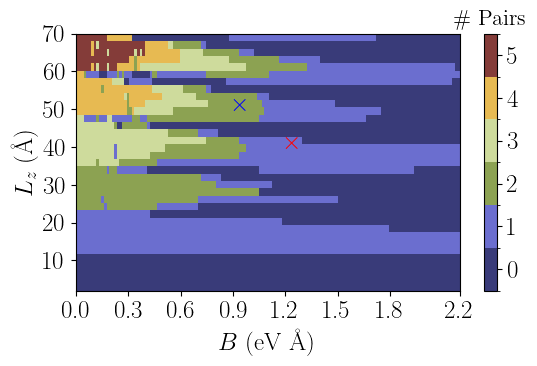

In [74]:
from matplotlib.colors import BoundaryNorm
import matplotlib.pyplot as plt
import numpy as np
from matplotlib.colors import ListedColormap

# valores únicos presentes
vals   = np.sort(np.unique(Ct))[:6]                # máximo cinco categorías
bounds = np.concatenate(([vals[0] - 0.5], vals + 0.5))
#cmap_d = plt.cm.get_cmap("tab20b", len(vals))    # exactamente n colores


# --- 1) colormap reducido con los 5 primeros colores -----------------
if hasattr(cmap_reused, "colors"):                       # p.ej. tab20*, Paired, etc.
    cmap5 = ListedColormap(cmap_reused.colors[:6], name="cmap5")
else:                                                    # colormap continuo (viridis, etc.)
    cmap5 = ListedColormap(cmap_reused(np.linspace(0, 1, 6)), name="cmap5")
norm   = BoundaryNorm(bounds, cmap5.N, clip=True)  # usa cmap5.N = 5


fig, ax = plt.subplots(figsize=(6, 4))

# heatmap categórico
im = ax.imshow(Ct,
               origin='lower',
               cmap=cmap5,
               norm=norm,
               aspect='auto',
               interpolation='none',
               extent=[p2_vals[0], p2_vals[-1], p1_vals[0], p1_vals[-1]])

ax.set_yticks(np.arange(10,71,10))               
ax.set_yticklabels(np.arange(10,71,10))

xticks = [0,0.3,0.6,0.9,1.2,1.5,1.8,2.2]
ax.set_xticks(xticks)
ax.set_xticklabels([f"{x:.1f}" for x in xticks])
ax.tick_params(labelsize=18)

# barra de color con los ticks bien definidos
cbar = fig.colorbar(im, ax=ax,
                    boundaries=bounds,
                    ticks=vals,
                    spacing='proportional')
cbar.ax.set_title("\# Pairs", pad=6)

# etiquetas
ax.set_xlabel(r"$B$ (eV Å)")
ax.set_ylabel(r"$L_z$ (Å)")

ax.text(0.9,50,r'$\times$',c='b')
ax.text(1.2,40,r'$\times$',c='r')

plt.tight_layout()

plt.savefig('Figs/SecIV/NumericalB_B.pdf')
plt.show()

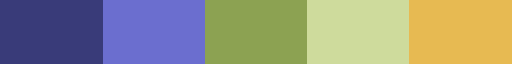

In [65]:
cmap_d

In [89]:
## Una QL son 10A, que son : Se-Bi-Se-Bi-Se. La c son aproximadamente 3 QLs

H_params = {
        "L_z":10 * 4 , ## 10 * QLs * SLABS
        "L_y":300,
        "C0":0.1, ## mu=56.3 meV [+ electrones, - huecos]
        "C2": 0,
        "C1": 0,
        "M0":-0.28, ## 0.28 eV
        "G":-0.46,
        "M1": 10,
        "M2": 56.59,
        "A" : 4.1,
        "B" : 1.2,  
        "T":0.45,
        "Delta": 0.1, ## 100 meV
        "a" : 4, ## 4  A
        "c":  2, ## Longitud QL / Nsitios
        "ky":0,
        "kz":0
            }

syst = Slab_BHZ_SC_kzky(H_params)

In [90]:
def sorted_eigs(ev):
    """ Function to sort the eigenvecs according to the eigenvalue order """ 
    evals, evecs = ev
    order = np.argsort(evals)
    return np.array(evals[order]), np.array(evecs[:, order])

from tqdm import tqdm  # Importar tqdm para la barra de progreso
import scipy.sparse.linalg as sla
import scipy.sparse as ss




a= H_params["a"]
c= H_params["c"]

Ly = H_params["L_y"]
Lz = H_params["L_z"]

Ly = int(Ly/a)
Lz = int(Lz/c)


print([Ly,Lz])

N_k      = 61
bands   = 14
kx_values = np.linspace(-0.05, 0.05, N_k)

energy_kx = []
eigenvectors_kx = []
previous_evecs = None

for ki in tqdm(kx_values, desc="Calculando Autovalores/Autovectores", unit="k-point"):
    H_params["kx"] = ki
    H_k = syst.hamiltonian_submatrix(params=H_params, sparse=True)


    ens, wfs = sla.eigsh(H_k.tocsc(), k=bands, sigma=0, return_eigenvectors=True)
    ens, wfs = sorted_eigs([ens, wfs])
    
    energy_kx.append(ens)
    eigenvectors_kx.append(wfs)



energy_kx = np.array(energy_kx)
eigenvectors_kx = np.array(eigenvectors_kx)
eigenvectors_kx = eigenvectors_kx.reshape([N_k, 8*Ly*Lz, bands])

[75, 20]


Calculando Autovalores/Autovectores: 100%|██████████| 61/61 [02:04<00:00,  2.05s/k-point]


In [91]:
Q_mat = np.kron(np.eye(Ly*Lz), kron3(sz, s0, s0))

# ---------- cálculos ----------
Nk, Nb = energy_kx.shape
Q_expect = np.empty((Nk, Nb))

Q_expect = np.einsum(
    'kan,ac,kcn->kn',                # índices: k a n · a c · k c n → k n
    np.conj(eigenvectors_kx),        # (Nk, 4L, Nb)  → k a n
    Q_mat,                           # (4L, 4L)      → a c
    eigenvectors_kx,                 # (Nk, 4L, Nb)  → k c n
    optimize=True                    # deja que NumPy elija la ruta óptima
).real 

Índices y energías seleccionadas en k=31:
   1) banda   6 : E = -0.00292 eV
   2) banda   7 : E =  0.00292 eV


/var/folders/tv/w7tvz05d1j781wvdwyk3sq100000gn/T/ipykernel_94262/1942324234.py:180: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


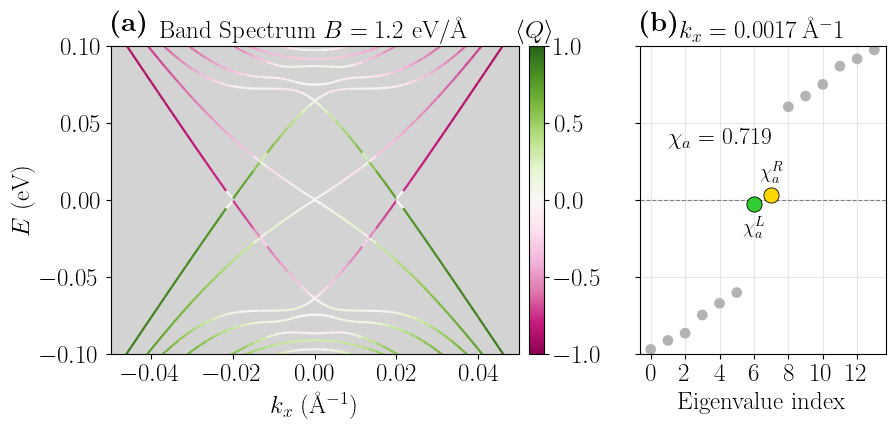

In [94]:
### 1) SELECCIÓN DE LOS 8 PRIMEROS ESTADOS (|E| más pequeños)
k_idx      = N_k // 2 + 1                      # k fijo (≈ centro)
energies_k = energy_kx[k_idx, :]

idx_sel    = np.argsort(np.abs(energies_k))[:2]   # ← ¡ahora son 4!
E_sel      = energies_k[idx_sel]

print("Índices y energías seleccionadas en k={}:".format(k_idx))
for i, (n, E) in enumerate(zip(idx_sel, E_sel), 1):
    print(f"  {i:2d}) banda {n:3d} : E = {E: .5f} eV")


L=Ly*Lz
### 2) POLARIZACIÓN DE MAJORANA PARA CADA ESTADO
C_mat  = np.kron(np.eye(L), kron3(sx, s0, s0))
chis   = []                                     # χ_i para i=1,…,8

for n in idx_sel:
    u = eigenvectors_kx[k_idx, :, n]            # (4L,)
    chi = np.abs(np.vdot(np.conj(u), C_mat @ np.conj(u)))**2
    chis.append(chi)

chis = np.array(chis)

### 3) FIGURA 1×2 (panel de bandas + espectro puntual) -------------
fig, (ax_band, ax_spec) = plt.subplots(
    1, 2, figsize=(10, 4), sharey=True,
    gridspec_kw={'width_ratios': [2, 1], 'wspace': 0.10}
)


# -------- 3a) Bandas E(kx) + proyección de carga ---------------------

from matplotlib.collections import LineCollection

Emin, Emax = -0.1, 0.1
cmap = plt.cm.PiYG
norm = plt.Normalize(vmin=-1, vmax=1)

for j in range(Nb):
    x = kx_values                      # (Nk,)
    y = energy_kx[:, j]                # (Nk,)
    q = Q_expect[:, j]                 # (Nk,)

    # 1) construye pares de puntos (x_i,y_i) → (x_{i+1},y_{i+1})
    pts      = np.column_stack([x, y]).reshape(-1, 1, 2)
    segments = np.concatenate([pts[:-1], pts[1:]], axis=1)   # (Nk-1, 2, 2)

    # 2) color de cada segmento = media de q_i y q_{i+1}
    q_seg = 0.5 * (q[:-1] + q[1:])      # (Nk-1,)

    # 3) crea la colección y añádela al eje
    lc = LineCollection(segments, cmap=cmap, norm=norm,
                        linewidths=1.6)
    lc.set_array(q_seg)
    ax_band.add_collection(lc)

# barra de color
sm = plt.cm.ScalarMappable(cmap=cmap, norm=norm)
sm.set_array([])
cbar = plt.colorbar(sm, ax=ax_band, pad=0.02)
cbar.ax.set_title(r'$\langle Q\rangle$')

# ejes y límites como antes
Emin, Emax = -0.1, 0.1
ax_band.set_xlim(kx_values[0], kx_values[-1])
ax_band.set_ylim(Emin, Emax)
ax_band.set_xlabel(r'$k_x$ (\AA$^{-1}$)')
ax_band.set_ylabel(r'$E$ (eV)')
ax_band.set_title('Band Spectrum + Charge Projection')
ax_band.grid(alpha=0.3)
ax_band.set_facecolor('lightgrey')

# → Etiqueta solo los 4 niveles con energía positiva
#    (entre los 8 de |E| más pequeño)
pos_idx   = np.where(E_sel > 0)[0]
# ordena ascendentemente por energía
pos_order = pos_idx[np.argsort(E_sel[pos_idx])]

y_pos=np.linspace(0.04,0.06,2)

letters = ['a', 'b']               # subíndices
y_pos = np.linspace(0.04, 0.06, 2) # alturas fijas

for rank, idx in enumerate(pos_order):          # solo 2 niveles >0
    E      = y_pos[rank]
    chival = chis[idx]
    ax_spec.text(4, E,                          # x = 4 (centro de panel)
                 fr'$\chi_{{{letters[rank]}}} = {chival:.3f}$',
                 fontsize=17, ha='center', va='center', zorder=5)

ax_band.set_xlim(kx_values[0], kx_values[-1])
ax_band.set_ylim(Emin, Emax)
ax_band.set_xlabel(r'$k_x$ (\AA$^{-1}$)')
ax_band.set_ylabel(r'$E$ (eV)')
ax_band.set_title(r'Band Spectrum $B=1.2$ eV/\AA')
ax_band.grid()

# -------- 3b) Espectro puntual ------------------------------------
energies     = energy_kx[k_idx]
sort_idx     = np.argsort(energies)
energies_ord = energies[sort_idx]

i0 = np.argmin(np.abs(energies_ord))
lo, hi = max(i0-20, 0), min(i0+20, len(energies_ord))

x_vals = np.arange(lo, hi)
E_vals = energies_ord[lo:hi]

thr = 0.05
base_colors = ['gold'      if  0 < E <= thr else
               'limegreen' if -thr <= E < 0 else
               '0.7' for E in E_vals]

ax_spec.scatter(x_vals, E_vals, s=45, c=base_colors, zorder=1)
ax_spec.axhline(0, ls='--', lw=0.8, color='grey')

# ---------- resaltado y etiquetas χ_{a,b}^{R/L} -------------------
letters = ['a', 'b']           # orden de letras
dy = 0.008                     # desplazamiento vertical (solo arriba/abajo)

# separa positivos y negativos
sel_pos = [(band, E) for band, E in zip(idx_sel, E_sel) if E > 0]
sel_neg = [(band, E) for band, E in zip(idx_sel, E_sel) if E < 0]

# ordena por |E| creciente
sel_pos.sort(key=lambda t: t[1])
sel_neg.sort(key=lambda t: abs(t[1]))

def highlight(selection, col, side, dy_sign):
    for rank, (band_idx, E) in enumerate(selection):
        w = np.where(sort_idx[lo:hi] == band_idx)[0]
        if not len(w):
            continue
        x = x_vals[w[0]]

        # punto destacado
        ax_spec.scatter(x, E, s=120, color=col,
                        edgecolor='k', linewidth=0.6, zorder=3)

        # etiqueta justo arriba/abajo
        m = letters[rank]          # 'a' o 'b'
        ax_spec.text(x, E + dy*dy_sign,
                     fr'$\chi_{m}$',
                     ha='center', va='center',
                     fontsize=14, zorder=4)

# aplica: R arriba, L abajo
# ---------- resaltado y etiquetas χ_{a,b}^{R/L} -------------------
letters = ['a', 'b']         # orden de letras ('a' → más cercano a 0)

def highlight(selection, col, side, dy_sign):
    dy = 0.015
    for rank, (band_idx, E) in enumerate(selection):
        w = np.where(sort_idx[lo:hi] == band_idx)[0]
        if not len(w):
            continue
        x = x_vals[w[0]]

        # punto grande
        ax_spec.scatter(x, E, s=120, color=col,
                        edgecolor='k', linewidth=0.6, zorder=3)

        # etiqueta:  χ^{R}_{a}   ó   χ^{L}_{b}
        label = fr'$\chi^{{{side}}}_{{{letters[rank]}}}$'
        ax_spec.text(x, E + dy*dy_sign, label,
                     ha='center', va='center', fontsize=14, zorder=4)

# aplica:   positivos → R (arriba)   /   negativos → L (abajo)
highlight(sel_pos, 'gold',      'R', +1)
highlight(sel_neg, 'limegreen', 'L', -1)

# ---------- ajuste final ------------------------------------------
ax_spec.set_xlabel(r'Eigenvalue index')
ax_spec.set_title(fr'$k_x = {kx_values[k_idx]:.4f}\,$\AA$^{-1}$')
ax_spec.set_xticks(x_vals[::2])
ax_spec.grid(alpha=0.3)

# -------- 4) SALIDA ----------------------------------------------
plt.tight_layout()
createletters((ax_band, ax_spec), coord=[0, 1.05])
plt.savefig('Figs/SecIV/BandsB12.svg', bbox_inches='tight')
plt.show()

kx selected: 0.0016666666666666705
Lx, Lz (number of sites): [75, 25]


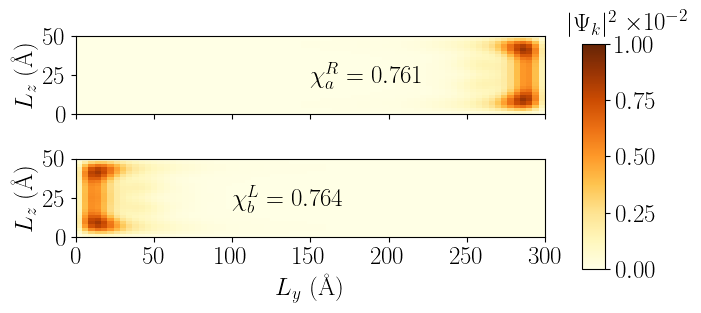

In [88]:
from matplotlib.lines import Line2D
from matplotlib.colors import Normalize
from matplotlib.cm import ScalarMappable
from matplotlib.ticker import FuncFormatter
import matplotlib.pyplot as plt

kx_selected_index = N_k//2+1

num_minima = 30

energies_for_kx = energy_kx[kx_selected_index, :]

sorted_indices = np.argsort(np.abs(energies_for_kx))[:num_minima]

min_values = [(band_idx, energies_for_kx[band_idx]) for band_idx in sorted_indices]

nbands = sorted_indices  


state0 = 0
state1 = 2
ki = [N_k // 2 + 1]
print("kx selected:", kx_values[ki[0]])

a = H_params["a"]
c = H_params["c"]

Ly = int(H_params["L_y"] / a)
Lz = int(H_params["L_z"] / c)

print("Lx, Lz (number of sites):", [Ly, Lz])


Dense   = kwant.operator.Density(syst, np.diag([1, 1, 1, 1,1,1,1,1]))
DenseSZ = kwant.operator.Density(syst, np.diag([1, -1, -1, 1,-1,1,-1,1]))
DensePQ = kwant.operator.Density(syst, np.diag([1, -1, 1, -1,1,-1,-1,1]))

u0 = eigenvectors_kx[ki[0], :, nbands[state0]]
u1 = eigenvectors_kx[ki[0], :, nbands[state1]]

en_state = energy_kx[ki[0], nbands[state0]]


avg    = np.sum(Dense(u0))
avg_SZ = np.sum(DenseSZ(u0))
avg_PQ = np.sum(DensePQ(u0))


legend_elements = [
    plt.Text(0, 0, fr'$<D> = {avg:.5f}$'),
    plt.Text(0, 0, fr'$|<\psi_k|S_z|\psi_k>| = {avg_SZ:.5f}$'),
    plt.Text(0, 0, fr'$|<\psi_k|P|\psi_k>| = {avg_PQ:.5f}$'),
    plt.Text(0, 0, fr'$E_k = {en_state:.6f}$'),
]

density_array0 = Dense(u0)
density_array1 = Dense(u1)

vmax = 1e-2
vmin = 0

norm = Normalize(vmin=vmin, vmax=vmax)
sm = ScalarMappable(norm=norm, cmap='YlOrBr')

plt.rcParams.update({         
    "font.size": 18,
    "axes.labelsize": 18,
    "xtick.labelsize": 18,
    "ytick.labelsize": 18
})

fig, axs = plt.subplots(2, 1, figsize=(10*0.75, 6*0.75), sharex=True)

extent = [0, Ly * a, 0, Lz * c]  

axs[0].imshow(density_array0.reshape([Ly, Lz]).T, origin='lower',
              extent=extent, vmin=vmin, vmax=vmax, cmap='YlOrBr')
axs[1].imshow(density_array1.reshape([Ly, Lz]).T, origin='lower',
              extent=extent, vmin=vmin, vmax=vmax, cmap='YlOrBr')

for ax in axs:
    ax.set_ylabel(r'$L_z$ ($\mathrm{\AA}$)')
    ax.set_yticks([0, 25, 50])               
    ax.set_yticklabels([0, 25,50])          
    ax.tick_params(labelsize=18)

axs[1].set_xlabel(r'$L_y$ ($\mathrm{\AA}$)')

fig.subplots_adjust(right=0.75, hspace=-0.45)

cbar_ax = fig.add_axes([0.8, 0.2, 0.03, 0.5])
cbar    = fig.colorbar(sm, cax=cbar_ax)
cbar.ax.set_title(r"$|\Psi_k|^2$", fontsize=18,pad=10)


cbar.formatter.set_scientific(True)
cbar.formatter.set_powerlimits((0, 0))
cbar.update_ticks()

cbar.ax.yaxis.get_offset_text().set_visible(False)

cbar.ax.text(
    2.,          
    1.05,           
    r"$\times 10^{-2}$",
    transform=cbar.ax.transAxes,
    ha='left', va='bottom',
    fontsize=18
)

axs[0].text(150, 20, rf'$\chi^R_a = {chis[state0]:.3f}$', fontsize=18)
axs[1].text( 100, 20, rf'$\chi^L_b = {chis[state1]:.3f}$', fontsize=18)

#plt.tight_layout()
plt.savefig('Figs/SecIV/StatesMajB09.pdf',bbox_inches='tight')
plt.show()

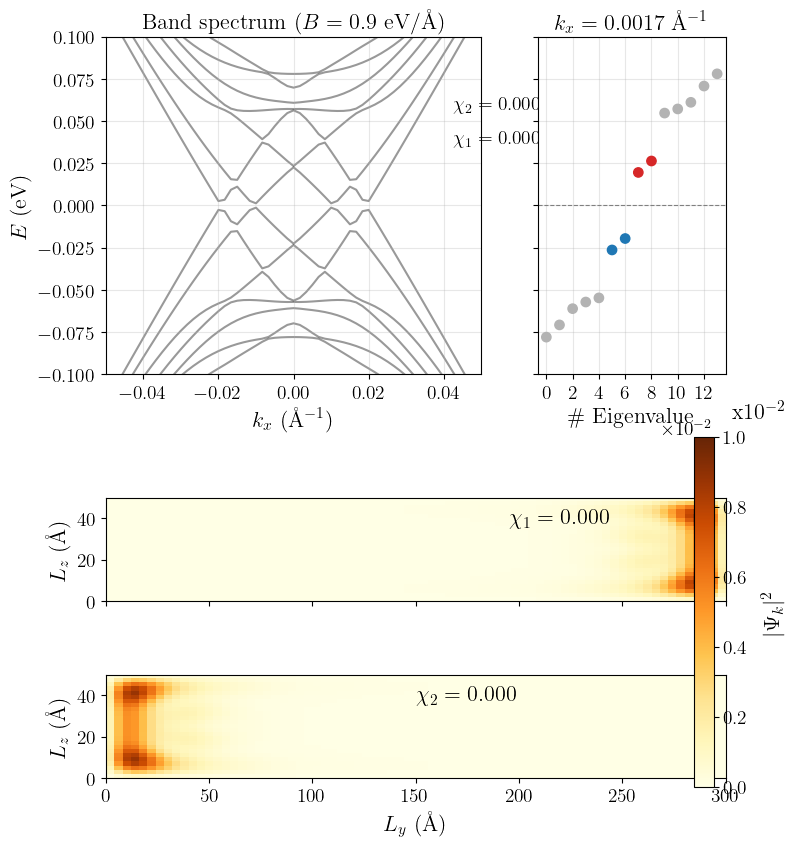

In [66]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.gridspec import GridSpec
from matplotlib.colors import Normalize
from matplotlib.cm import ScalarMappable

# ───────────────────────────────────────────
# 1) PREPARATIVOS (elige k fijo y estados)
# ───────────────────────────────────────────
N_k          = energy_kx.shape[0] - 1
k_idx        = N_k // 2 + 1                    # k≈centro
energies_k   = energy_kx[k_idx, :]

# ← aquí seleccionamos los 4 |E| más pequeños
idx_sel      = np.argsort(np.abs(energies_k))[:4]
E_sel        = energies_k[idx_sel]

# MATRIZ de polarización de Majorana (ejemplo 8×8)
L  = int(H_params["L_y"]/H_params["a"]) * int(H_params["L_z"]/H_params["c"])
sx = np.array([[0, 1], [1, 0]])
s0 = np.eye(2)
def kron3(a, b, c): return np.kron(np.kron(a, b), c)
C_mat  = np.kron(np.eye(L), kron3(sx, s0, s0))

chis = []
for n in idx_sel:
    u = eigenvectors_kx[k_idx, :, n]            # (4L,)
    chi = np.abs(np.conj(u) @ (C_mat @ u.conj()))**2
    chis.append(chi)
chis = np.array(chis)

# ───────────────────────────────────────────
# 2) DENSIDADES (dos estados a mostrar)
# ───────────────────────────────────────────
Dense   = kwant.operator.Density(syst, np.diag([1]*8))
state0, state1 = 0, 1                          # índices dentro de idx_sel

u0 = eigenvectors_kx[k_idx, :, idx_sel[state0]]
u1 = eigenvectors_kx[k_idx, :, idx_sel[state1]]

density0 = Dense(u0)
density1 = Dense(u1)

# Dimensiones reales
a, c     = H_params["a"], H_params["c"]
Ly       = int(H_params["L_y"]/a)
Lz       = int(H_params["L_z"]/c)
extent   = [0, Ly*a, 0, Lz*c]

# ───────────────────────────────────────────
# 3) FIGURA COMPUESTA
# ───────────────────────────────────────────
plt.rcParams.update({
    "font.size": 16,
    "axes.labelsize": 16,
    "xtick.labelsize": 14,
    "ytick.labelsize": 14
})

fig = plt.figure(figsize=(8, 10))
gs  = GridSpec(2, 1, height_ratios=[1.0, 1.0], hspace=0.28)

# ─── Panel superior (1×2) ──────────────────
gs_top  = gs[0].subgridspec(1, 2, width_ratios=[2, 1], wspace=0.20)
ax_band = fig.add_subplot(gs_top[0])
ax_spec = fig.add_subplot(gs_top[1], sharey=ax_band) 

ax_spec.tick_params(labelleft=False)

# (a) Bandas E(kx)
Emin, Emax = -0.1, 0.1
for j in range(energy_kx.shape[1]):
    ax_band.plot(kx_values, energy_kx[:, j], c='k', alpha=0.4, zorder=1)

# Etiquetas χ_i solo para E>0
pos_idx   = np.where(E_sel > 0)[0]
pos_order = pos_idx[np.argsort(E_sel[pos_idx])]
y_pos     = np.linspace(0.04, 0.06, len(pos_order))

for n_plot, idx in enumerate(pos_order, 1):
    ax_band.text(kx_values[-1]*0.85, y_pos[n_plot-1],
                 fr'$\chi_{n_plot}={chis[idx]:.4f}$',
                 fontsize=14, va='center')

ax_band.set(xlim=(kx_values[0], kx_values[-1]),
            ylim=(Emin, Emax),
            xlabel=r'$k_x$ (Å$^{-1}$)',
            ylabel=r'$E$ (eV)',
            title=r'Band spectrum ($B=0.9$ eV/Å)')
ax_band.grid(alpha=0.3)

# (b) Espectro puntual
ener_sorted = np.sort(energies_k)
center      = np.argmin(np.abs(ener_sorted))
lo, hi      = max(center-20, 0), min(center+20, len(ener_sorted))
sel_idx     = np.arange(lo, hi)
E_sel_spec  = ener_sorted[lo:hi]

thr = 0.05
colors = ['tab:red'  if 0 < E <= thr else
          'tab:blue' if -thr <= E < 0 else
          '0.7' for E in E_sel_spec]

ax_spec.scatter(sel_idx, E_sel_spec, s=45, c=colors, zorder=3)
ax_spec.axhline(0, ls='--', lw=0.8, color='grey')
ax_spec.set(xlabel=r'$\#$ Eigenvalue',
            title=fr'$k_x={kx_values[k_idx]:.4f}$ Å$^{{-1}}$')
ax_spec.set_xticks(sel_idx[::2])
ax_spec.grid(alpha=0.3)

# ─── Panel inferior (2×1) ──────────────────
gs_bot = gs[1].subgridspec(2, 1, hspace=0.1)
ax_d0  = fig.add_subplot(gs_bot[0])
ax_d1  = fig.add_subplot(gs_bot[1], sharex=ax_d0)

ax_d0.tick_params(labelbottom=False)

vmax = 1e-2
norm = Normalize(vmin=0, vmax=vmax)
cmap = 'YlOrBr'
sm   = ScalarMappable(norm=norm, cmap=cmap)

ax_d0.imshow(density0.reshape(Ly, Lz).T, origin='lower',
             extent=extent, cmap=cmap, norm=norm)
ax_d1.imshow(density1.reshape(Ly, Lz).T, origin='lower',
             extent=extent, cmap=cmap, norm=norm)

for ax in (ax_d0, ax_d1):
    ax.set_ylabel(r'$L_z$ (Å)')
    ax.set_yticks([0, 20, 40])

ax_d1.set_xlabel(r'$L_y$ (Å)')

ax_d0.text(Ly*a*0.65, Lz*c*0.75,
           rf'$\chi_1 = {chis[state0]:.3f}$', fontsize=16, color='k')
ax_d1.text(Ly*a*0.50, Lz*c*0.75,
           rf'$\chi_2 = {chis[state1]:.3f}$', fontsize=16, color='k')

# Barra de color común
cax = fig.add_axes([0.86, 0.13, 0.025, 0.35])
cbar = fig.colorbar(sm, cax=cax)
cbar.set_label(r'$|\Psi_k|^2$', fontsize=16, labelpad=10)
cbar.formatter.set_powerlimits((0, 0))
cbar.update_ticks()
cbar.ax.text(1.9, 1.04, r'x10$^{-2}$',
             transform=cbar.ax.transAxes, ha='left', va='bottom', fontsize=16)

# ───────────────────────────────────────────
plt.savefig('Figs/SecIV/Composite_B09.pdf', bbox_inches='tight')
plt.show()

## Heterostrcutures

In [1]:
import sys

sys.path.append('..')

from FuncsChern import *
import numpy as np
import kwant

# Pauli matrices
sx = np.array([[0, 1],[1, 0]], dtype=complex)
sy = np.array([[0, -1j],[1j, 0]], dtype=complex)
sz = np.array([[1, 0],[0, -1]], dtype=complex)
s0 = np.eye(2, dtype=complex)

def sorted_eigs(ev):
    """ Function to sort the eigenvecs according to the eigenvalue order """ 
    evals, evecs = ev
    order = np.argsort(evals)
    return np.array(evals[order]), np.array(evecs[:, order])

from tqdm import tqdm  # Importar tqdm para la barra de progreso
import scipy.sparse.linalg as sla

def kron3(A, B, C):
    return np.kron(np.kron(A, B), C)

def Matrices_Gamma():

    Gz00 = kron3(sz,s0,s0)
    Gz0z = kron3(sz,s0,sz)
    G00x = kron3(s0,s0,sx)
    Gzzy = kron3(sz,sz,sy)
    Gzzz = kron3(sz,sz,sz)
    G0yy = kron3(s0,sy,sy)
    Gyyz = kron3(sy,sy,sz)
    Gxyz = kron3(sx,sy,sz)
    Gzyy = kron3(sz,sy,sy)
    Gzxx = kron3(sz,sx,sx)

    return Gz00, Gz0z, G00x, Gzzy, Gzzz, G0yy, Gyyz, Gzyy, Gxyz, Gzxx

Gz00, Gz0z, G00x, Gzzy, Gzzz, G0yy, Gyyz, Gzyy, Gxyz, Gzxx = Matrices_Gamma()


def Slab_BHZ_SC_kzky_HETERO(params):
    a   = params["a"]
    c   = params["c"]
    L_y = params["L_y"]  
    L_z = params["L_z"]  

    ##Tengo que cambiar esto  ¿?
    ## No estoy de acuerdo con tener que cambiar c, c es el periodo con el que se repite la celda. 

    lat = kwant.lattice.general([(a, 0), (0, c)], basis=[(0, 0)], norbs=8)

    def onsite(site, kx, a,c, C0, C1, C2, M0vec,M0_func, M1, M2, A, G_func, Gvec, Delta, Delta_func,Delta2, Delta_func2, alpha,beta, T_func,Tvec):
            z = int(site.tag[1])
            ck2_xy = 2.0 - np.cos(kx * a)
            ck2_z = 1
            epsilon_0 = C0 + (2 * C2 / (a ** 2)) * ck2_xy + (2 * C1 / (c ** 2)) * ck2_z
            M_0 = M0_func(z, L_z/c, M0vec) + (2 * M2 / (a ** 2)) * ck2_xy + (2 * M1 / (c ** 2))* ck2_z
            
            OS_matrix = (
                epsilon_0 * Gz00 +
                (A/a) * (np.sin(kx * a) * G00x) +
                M_0 * Gz0z +
                G_func(z, L_z/c, Gvec) * Gzzz +
            np.real(Delta_func(z, alpha, Delta,L_z/c,c)+ Delta_func(z, alpha, Delta2,L_z/c,c)) * Gyyz+
            np.imag(Delta_func(z, alpha, Delta,L_z/c,c)+ Delta_func(z, alpha, Delta2,L_z/c,c)) * Gxyz
            +T_func(z, L_z/c, Tvec)*Gzyy)
            return OS_matrix

    # Hopping en dirección z
    def hopping_z(site1, site2, c, C1, M1, B,T):
        #z = int(site1.tag[1])
        return (C1 / c**2) * Gz00 + (M1 / c**2) * Gz0z + (1j * B / (2 * c) * G0yy)

    # Hopping en dirección y
    def hopping_y(site1, site2, a, C2, M2, A):

        return (C2 / a**2) * Gz00 + (M2 / a**2) * Gz0z + (1j * A) / (2 * a) * Gzzy

    syst = kwant.Builder()

    
    def shape(pos):
        y, z = pos 
        return (0 <= y < L_y) and (0 <= z < L_z)

    
    syst[lat.shape(shape, (0, 0))] = onsite

    # Hoppings en la dirección y
    syst[kwant.builder.HoppingKind((1, 0), lat.sublattices[0], lat.sublattices[0])] = hopping_y
    #syst[kwant.builder.HoppingKind((-1, 0), lat.sublattices[0], lat.sublattices[0])] = (
    #    lambda s1, s2, a, C2, M2, A: np.conjugate(hopping_y(s2, s1, a, C2, M2, A).T)
    #)

    # Hoppings en la dirección z
    syst[kwant.builder.HoppingKind((0, 1), lat.sublattices[0], lat.sublattices[0])] = hopping_z
    #syst[kwant.builder.HoppingKind((0, -1), lat.sublattices[0], lat.sublattices[0])] = (
    #    lambda s1, s2, c, C1, M1, B: np.conjugate(hopping_z(s2, s1, c, C1, M1, B).T)
    #)

    return syst.finalized()

/opt/anaconda3/lib/python3.12/site-packages/kwant/solvers/default.py:16: RuntimeWarning: MUMPS is not available, SciPy built-in solver will be used as a fallback. Performance can be very poor in this case.
  warnings.warn("MUMPS is not available, "


In [2]:
def M0_func(z, L_z, M0vec):
    if z<4/10*L_z:
        return M0vec[0]
    else:
        if z<6/10*L_z:
            return M0vec[1]
        else:
            return M0vec[2]


def Delta_func(z, alpha, Delta,L,c):
    return np.abs(Delta * (1-alpha*z/(L)))*np.exp(1j*np.angle(Delta)) 

def Delta_func2(z, alpha, Delta,L,c):
    return np.abs(Delta * (alpha*z/(L)))*np.exp(1j*np.angle(Delta)) 

def G_func(z, L_z, Gvec):
    if z<4/10*L_z:
        return Gvec[0]
    else:
        if z<6/10*L_z:
            return Gvec[1]
        else:
            return Gvec[2]
        
def T_func(z, L_z, Tvec):
    if z<1/2*L_z:
        return Tvec[0]
    else:
        if z<L_z:
            return Tvec[1]
        else:
            return Tvec[2]

def B_func(z, L_z, Bvec):
    if z<1/2*L_z:
        return Bvec[0]
    else:
        if z<L_z:
            return Bvec[1]
        else:
            return Bvec[2]

#c=28.64
#a=4.14

## Una QL son 10A, que son : Se-Bi-Se-Bi-Se. La c son aproximadamente 3 QLs

H_params = {
        "L_z":10 * 10 , ## 10 * QLs * SLABS
        "L_y":300,
        "C0":0.1, ## mu=56.3 meV [+ electrones, - huecos]
        "C2": 0,
        "C1": 0,
        "M0vec":[-0.28,10,-0.28], ## 0.28 eV
        #"Gvec":[0.5,0.5,0.5],
        "Gvec":[-0.46,0., 0.46],  ## 0.46 eV
        "M1": 10,
        "M2": 56.59,
        "A" : 4.1,
        "B" : 0,  
        #"Bvec":[0.,0.,0],
         #"T" : 0.5,
        "T":0.45, ## 0.45 eV
        "Tvec":[0.45,0.45,0.45],
        "Delta": 0.1, ## 100 meV
        "Delta2":0,
        "a" : 4, ## 4  A
        "c":  2, ## Longitud QL / Nsitios
        "alpha": 0,
        "beta":0,
        "M0_func": M0_func,
        "T_func": T_func,
        "G_func": G_func,
        #"B_func": B_func,
        "Delta_func": Delta_func, 
        "Delta_func2": Delta_func2,
        "ky":0,
            }

syst = Slab_BHZ_SC_kzky_HETERO(H_params)

In [3]:
def sorted_eigs(ev):
    """ Function to sort the eigenvecs according to the eigenvalue order """ 
    evals, evecs = ev
    order = np.argsort(evals)
    return np.array(evals[order]), np.array(evecs[:, order])

from tqdm import tqdm  # Importar tqdm para la barra de progreso
import scipy.sparse.linalg as sla
import scipy.sparse as ss




a= H_params["a"]
c= H_params["c"]

Ly = H_params["L_y"]
Lz = H_params["L_z"]

Ly = int(Ly/a)
Lz = int(Lz/c)


print([Ly,Lz])

N_k      = 31
bands   = 20
kx_values = np.linspace(-0.05, 0.05, N_k)

energy_kx = []
eigenvectors_kx = []
previous_evecs = None

for ki in tqdm(kx_values, desc="Calculando Autovalores/Autovectores", unit="k-point"):
    H_params["kx"] = ki
    H_k = syst.hamiltonian_submatrix(params=H_params, sparse=True)


    ens, wfs = sla.eigsh(H_k.tocsc(), k=bands, sigma=0, return_eigenvectors=True)
    ens, wfs = sorted_eigs([ens, wfs])
    
    energy_kx.append(ens)
    eigenvectors_kx.append(wfs)



energy_kx = np.array(energy_kx)
eigenvectors_kx = np.array(eigenvectors_kx)
eigenvectors_kx = eigenvectors_kx.reshape([N_k, 8*Ly*Lz, bands])

[75, 50]


Calculando Autovalores/Autovectores: 100%|██████████| 31/31 [06:54<00:00, 13.37s/k-point]


In [4]:
Q_mat = np.kron(np.eye(Ly*Lz), kron3(sz, s0, s0))

# ---------- cálculos ----------
Nk, Nb = energy_kx.shape
Q_expect = np.empty((Nk, Nb))

Q_expect = np.einsum(
    'kan,ac,kcn->kn',                # índices: k a n · a c · k c n → k n
    np.conj(eigenvectors_kx),        # (Nk, 4L, Nb)  → k a n
    Q_mat,                           # (4L, 4L)      → a c
    eigenvectors_kx,                 # (Nk, 4L, Nb)  → k c n
    optimize=True                    # deja que NumPy elija la ruta óptima
).real 

In [5]:
### 1) SELECCIÓN DE LOS 8 PRIMEROS ESTADOS (|E| más pequeños)
k_idx      = N_k // 2 + 1                      # k fijo (≈ centro)
energies_k = energy_kx[k_idx, :]

idx_sel    = np.argsort(np.abs(energies_k))[:12]   # ← ¡ahora son 4!
E_sel      = energies_k[idx_sel]

print("Índices y energías seleccionadas en k={}:".format(k_idx))
for i, (n, E) in enumerate(zip(idx_sel, E_sel), 1):
    print(f"  {i:2d}) banda {n:3d} : E = {E: .5f} eV")


L=Ly*Lz
### 2) POLARIZACIÓN DE MAJORANA PARA CADA ESTADO
C_mat  = np.kron(np.eye(L), kron3(sx, s0, s0))
chis   = []                                     # χ_i para i=1,…,8

for n in idx_sel:
    u = eigenvectors_kx[k_idx, :, n]            # (4L,)
    chi = np.abs(np.vdot(np.conj(u), C_mat @ np.conj(u)))**2
    chis.append(chi)

chis = np.array(chis)

### 3) FIGURA 1×2 (panel de bandas + espectro puntual) -------------
fig, (ax_band, ax_spec) = plt.subplots(
    1, 2, figsize=(10, 4), sharey=True,
    gridspec_kw={'width_ratios': [2, 1], 'wspace': 0.10}
)


# -------- 3a) Bandas E(kx) + proyección de carga ---------------------

from matplotlib.collections import LineCollection

Emin, Emax = -0.1, 0.1
cmap = plt.cm.PiYG
norm = plt.Normalize(vmin=-1, vmax=1)

for j in range(Nb):
    x = kx_values                      # (Nk,)
    y = energy_kx[:, j]                # (Nk,)
    q = Q_expect[:, j]                 # (Nk,)

    # 1) construye pares de puntos (x_i,y_i) → (x_{i+1},y_{i+1})
    pts      = np.column_stack([x, y]).reshape(-1, 1, 2)
    segments = np.concatenate([pts[:-1], pts[1:]], axis=1)   # (Nk-1, 2, 2)

    # 2) color de cada segmento = media de q_i y q_{i+1}
    q_seg = 0.5 * (q[:-1] + q[1:])      # (Nk-1,)

    # 3) crea la colección y añádela al eje
    lc = LineCollection(segments, cmap=cmap, norm=norm,
                        linewidths=1.6)
    lc.set_array(q_seg)
    ax_band.add_collection(lc)

# barra de color
sm = plt.cm.ScalarMappable(cmap=cmap, norm=norm)
sm.set_array([])
cbar = plt.colorbar(sm, ax=ax_band, pad=0.02)
cbar.ax.set_title(r'$\langle Q\rangle$')

# ejes y límites como antes
Emin, Emax = -0.1, 0.1
ax_band.set_xlim(kx_values[0], kx_values[-1])
ax_band.set_ylim(Emin, Emax)
ax_band.set_xlabel(r'$k_x$ (\AA$^{-1}$)')
ax_band.set_ylabel(r'$E$ (eV)')
ax_band.set_title('Band Spectrum + Charge Projection')
ax_band.grid(alpha=0.3)
ax_band.set_facecolor('lightgrey')

# → Etiqueta solo los 4 niveles con energía positiva
#    (entre los 8 de |E| más pequeño)
pos_idx   = np.where(E_sel > 0)[0]
# ordena ascendentemente por energía
pos_order = pos_idx[np.argsort(E_sel[pos_idx])]

y_pos=np.linspace(0.04,0.06,2)

letters = ['1', '2','3','1','2','3']               # subíndices
y_pos = np.linspace(0.04, 0.06, 2) # alturas fijas

for rank, idx in enumerate(pos_order):          # solo 2 niveles >0
    E      = y_pos[rank]
    chival = chis[idx]
    ax_spec.text(4, E,                          # x = 4 (centro de panel)
                 fr'$\chi_{{{letters[rank]}}} = {chival:.3f}$',
                 fontsize=17, ha='center', va='center', zorder=5)

ax_band.set_xlim(kx_values[0], kx_values[-1])
ax_band.set_ylim(Emin, Emax)
ax_band.set_xlabel(r'$k_x$ (\AA$^{-1}$)')
ax_band.set_ylabel(r'$E$ (eV)')
ax_band.set_title(r'Band Spectrum')
ax_band.grid()

# -------- 3b) Espectro puntual ------------------------------------
energies     = energy_kx[k_idx]
sort_idx     = np.argsort(energies)
energies_ord = energies[sort_idx]

i0 = np.argmin(np.abs(energies_ord))
lo, hi = max(i0-20, 0), min(i0+20, len(energies_ord))

x_vals = np.arange(lo, hi)
E_vals = energies_ord[lo:hi]

thr = 0.05
base_colors = ['gold'      if  0 < E <= thr else
               'limegreen' if -thr <= E < 0 else
               '0.7' for E in E_vals]

ax_spec.scatter(x_vals, E_vals, s=45, c=base_colors, zorder=1)
ax_spec.axhline(0, ls='--', lw=0.8, color='grey')

# ---------- resaltado y etiquetas χ_{a,b}^{R/L} -------------------
letters = ['a', 'b']           # orden de letras
dy = 0.008                     # desplazamiento vertical (solo arriba/abajo)

# separa positivos y negativos
sel_pos = [(band, E) for band, E in zip(idx_sel, E_sel) if E > 0]
sel_neg = [(band, E) for band, E in zip(idx_sel, E_sel) if E < 0]

# ordena por |E| creciente
sel_pos.sort(key=lambda t: t[1])
sel_neg.sort(key=lambda t: abs(t[1]))

def highlight(selection, col, side, dy_sign):
    for rank, (band_idx, E) in enumerate(selection):
        w = np.where(sort_idx[lo:hi] == band_idx)[0]
        if not len(w):
            continue
        x = x_vals[w[0]]

        # punto destacado
        ax_spec.scatter(x, E, s=120, color=col,
                        edgecolor='k', linewidth=0.6, zorder=3)

        # etiqueta justo arriba/abajo
        m = letters[rank]          # 'a' o 'b'
        ax_spec.text(x, E + dy*dy_sign,
                     fr'$\chi_{m}$',
                     ha='center', va='center',
                     fontsize=14, zorder=4)

# aplica: R arriba, L abajo
# ---------- resaltado y etiquetas χ_{a,b}^{R/L} -------------------
letters = ['a', 'b']         # orden de letras ('a' → más cercano a 0)

def highlight(selection, col, side, dy_sign):
    dy = 0.015
    for rank, (band_idx, E) in enumerate(selection):
        w = np.where(sort_idx[lo:hi] == band_idx)[0]
        if not len(w):
            continue
        x = x_vals[w[0]]

        # punto grande
        ax_spec.scatter(x, E, s=120, color=col,
                        edgecolor='k', linewidth=0.6, zorder=3)

        # etiqueta:  χ^{R}_{a}   ó   χ^{L}_{b}
        label = fr'$\chi^{{{side}}}_{{{letters[rank]}}}$'
        ax_spec.text(x, E + dy*dy_sign, label,
                     ha='center', va='center', fontsize=14, zorder=4)

# aplica:   positivos → R (arriba)   /   negativos → L (abajo)
highlight(sel_pos, 'gold',      'R', +1)
highlight(sel_neg, 'limegreen', 'L', -1)

# ---------- ajuste final ------------------------------------------
ax_spec.set_xlabel(r'Eigenvalue index')
ax_spec.set_title(fr'$k_x = {kx_values[k_idx]:.4f}\,$\AA$^{-1}$')
ax_spec.set_xticks(x_vals[::2])
ax_spec.grid(alpha=0.3)

# -------- 4) SALIDA ----------------------------------------------
plt.tight_layout()
createletters((ax_band, ax_spec), coord=[0, 1.05])
plt.savefig('Figs/SecIV/BandsGins.svg', bbox_inches='tight')
plt.show()

Índices y energías seleccionadas en k=16:
   1) banda   9 : E = -0.00657 eV
   2) banda   8 : E = -0.00657 eV
   3) banda  10 : E =  0.00657 eV
   4) banda  11 : E =  0.00657 eV
   5) banda   7 : E = -0.00716 eV
   6) banda   6 : E = -0.00716 eV
   7) banda  12 : E =  0.00716 eV
   8) banda  13 : E =  0.00716 eV
   9) banda   5 : E = -0.00761 eV
  10) banda   4 : E = -0.00761 eV
  11) banda  14 : E =  0.00761 eV
  12) banda  15 : E =  0.00761 eV


: 

kx selected: 0.003333333333333334
Lx, Lz (number of sites): [75, 50]


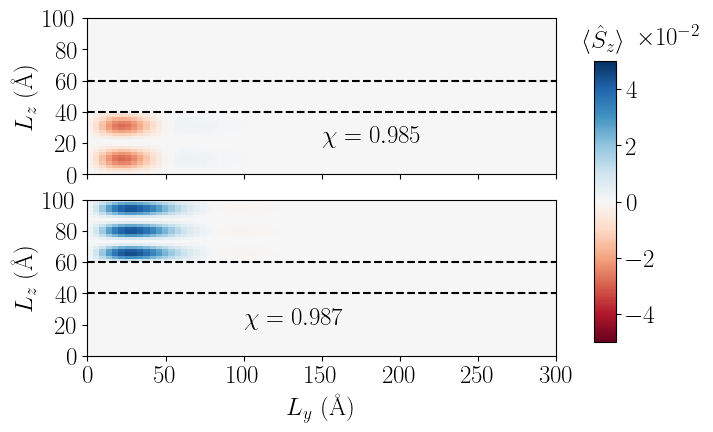

In [158]:
from matplotlib.lines import Line2D
from matplotlib.colors import Normalize
from matplotlib.cm import ScalarMappable
from matplotlib.ticker import FuncFormatter
import matplotlib.pyplot as plt

kx_selected_index = N_k//2+1

num_minima = 30

energies_for_kx = energy_kx[kx_selected_index, :]

sorted_indices = np.argsort(np.abs(energies_for_kx))[:num_minima]

min_values = [(band_idx, energies_for_kx[band_idx]) for band_idx in sorted_indices]

nbands = sorted_indices  

state0 = 0
state1 = 10
ki = [N_k // 2 + 1]
print("kx selected:", kx_values[ki[0]])

a = H_params["a"]
c = H_params["c"]

Ly = int(H_params["L_y"] / a)
Lz = int(H_params["L_z"] / c)

print("Lx, Lz (number of sites):", [Ly, Lz])

Dense   = kwant.operator.Density(syst, np.diag([1, 1, 1, 1,1,1,1,1]))
DenseSZ = kwant.operator.Density(syst, np.diag([1, -1, -1, 1,-1,1,-1,1]))
DensePQ = kwant.operator.Density(syst, np.diag([1, -1, 1, -1,1,-1,-1,1]))

u0 = eigenvectors_kx[ki[0], :, nbands[state0]]
u1 = eigenvectors_kx[ki[0], :, nbands[state1]]

en_state = energy_kx[ki[0], nbands[state0]]

avg    = np.sum(Dense(u0))
avg_SZ = np.sum(DenseSZ(u0))
avg_PQ = np.sum(DensePQ(u0))

legend_elements = [
    plt.Text(0, 0, fr'$<D> = {avg:.5f}$'),
    plt.Text(0, 0, fr'$|<\psi_k|S_z|\psi_k>| = {avg_SZ:.5f}$'),
    plt.Text(0, 0, fr'$|<\psi_k|P|\psi_k>| = {avg_PQ:.5f}$'),
    plt.Text(0, 0, fr'$E_k = {en_state:.6f}$'),
]

density_array0 = DenseSZ(u0)
density_array1 = DenseSZ(u1)

vmax = 5e-3
vmin = -5e-3

norm = Normalize(vmin=vmin, vmax=vmax)
#sm = ScalarMappable(norm=norm, cmap='YlOrBr')
sm = ScalarMappable(norm=norm, cmap='RdBu')

plt.rcParams.update({         
    "font.size": 18,
    "axes.labelsize": 18,
    "xtick.labelsize": 18,
    "ytick.labelsize": 18
})

fig, axs = plt.subplots(2, 1, figsize=(10*0.75, 6*0.75), sharex=True,sharey=True)

extent = [0, Ly * a, 0, Lz * c]  

axs[0].imshow(density_array0.reshape([Ly, Lz]).T, origin='lower',
              extent=extent, vmin=vmin, vmax=vmax, cmap='RdBu')
axs[1].imshow(density_array1.reshape([Ly, Lz]).T, origin='lower',
              extent=extent, vmin=vmin, vmax=vmax, cmap='RdBu')

for ax in axs:
    ax.set_ylabel(r'$L_z$ ($\mathrm{\AA}$)')
    ax.set_yticks([0, 20, 40,60,80,100])               
    ax.set_yticklabels([0, 20,40,60,80,100])          
    ax.tick_params(labelsize=18)
    ax.axhline(40,ls='--',c='k')
    ax.axhline(60,ls='--',c='k')

axs[1].set_xlabel(r'$L_y$ ($\mathrm{\AA}$)')

fig.subplots_adjust(right=0.75, hspace=0.1)

cbar_ax = fig.add_axes([0.8, 0.15, 0.03, 0.625])
cbar    = fig.colorbar(sm, cax=cbar_ax)
cbar.ax.set_title(r"$\langle \hat{S}_z \rangle$", fontsize=18,pad=10)

cbar.formatter.set_scientific(True)
cbar.formatter.set_powerlimits((0, 0))
cbar.update_ticks()

cbar.ax.yaxis.get_offset_text().set_visible(False)

cbar.ax.text(
    2.,          
    1.05,           
    r"$\times 10^{-2}$",
    transform=cbar.ax.transAxes,
    ha='left', va='bottom',
    fontsize=18
)

axs[0].text(150, 20, rf'$\chi = {chis[state0]:.3f}$', fontsize=18)
axs[1].text( 100, 20, rf'$\chi = {chis[state1]:.3f}$', fontsize=18)

#plt.tight_layout()
plt.savefig('Figs/SecIV/StatesMajHeteroSGvaluesIns.svg')
plt.show()

kx selected: 0.003333333333333334
Lx, Lz (number of sites): [75, 50]


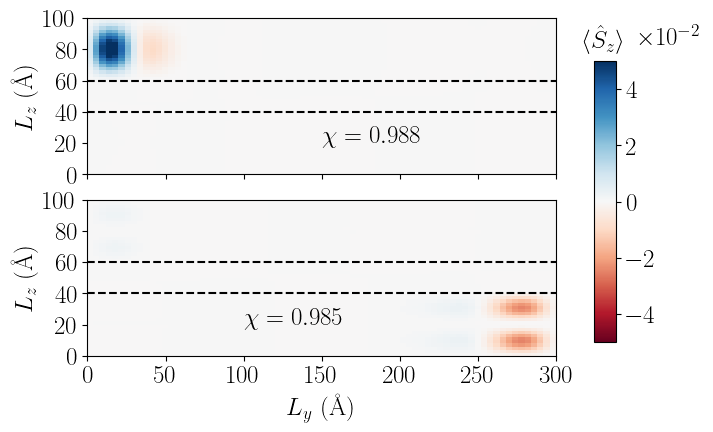

In [169]:
from matplotlib.lines import Line2D
from matplotlib.colors import Normalize
from matplotlib.cm import ScalarMappable
from matplotlib.ticker import FuncFormatter
import matplotlib.pyplot as plt

kx_selected_index = N_k//2+1

num_minima = 30

energies_for_kx = energy_kx[kx_selected_index, :]

sorted_indices = np.argsort(np.abs(energies_for_kx))[:num_minima]

min_values = [(band_idx, energies_for_kx[band_idx]) for band_idx in sorted_indices]

nbands = sorted_indices  

state0 = 6
state1 = 3
ki = [N_k // 2 + 1]
print("kx selected:", kx_values[ki[0]])

a = H_params["a"]
c = H_params["c"]

Ly = int(H_params["L_y"] / a)
Lz = int(H_params["L_z"] / c)

print("Lx, Lz (number of sites):", [Ly, Lz])

Dense   = kwant.operator.Density(syst, np.diag([1, 1, 1, 1,1,1,1,1]))
DenseSZ = kwant.operator.Density(syst, np.diag([1, -1, -1, 1,-1,1,-1,1]))
DensePQ = kwant.operator.Density(syst, np.diag([1, -1, 1, -1,1,-1,-1,1]))

u0 = eigenvectors_kx[ki[0], :, nbands[state0]]
u1 = eigenvectors_kx[ki[0], :, nbands[state1]]

en_state = energy_kx[ki[0], nbands[state0]]

avg    = np.sum(Dense(u0))
avg_SZ = np.sum(DenseSZ(u0))
avg_PQ = np.sum(DensePQ(u0))

legend_elements = [
    plt.Text(0, 0, fr'$<D> = {avg:.5f}$'),
    plt.Text(0, 0, fr'$|<\psi_k|S_z|\psi_k>| = {avg_SZ:.5f}$'),
    plt.Text(0, 0, fr'$|<\psi_k|P|\psi_k>| = {avg_PQ:.5f}$'),
    plt.Text(0, 0, fr'$E_k = {en_state:.6f}$'),
]

density_array0 = DenseSZ(u0)
density_array1 = DenseSZ(u1)

vmax = 5e-3
vmin = -5e-3

norm = Normalize(vmin=vmin, vmax=vmax)
#sm = ScalarMappable(norm=norm, cmap='YlOrBr')
sm = ScalarMappable(norm=norm, cmap='RdBu')

plt.rcParams.update({         
    "font.size": 18,
    "axes.labelsize": 18,
    "xtick.labelsize": 18,
    "ytick.labelsize": 18
})

fig, axs = plt.subplots(2, 1, figsize=(10*0.75, 6*0.75), sharex=True,sharey=True)

extent = [0, Ly * a, 0, Lz * c]  

axs[0].imshow(density_array0.reshape([Ly, Lz]).T, origin='lower',
              extent=extent, vmin=vmin, vmax=vmax, cmap='RdBu')
axs[1].imshow(density_array1.reshape([Ly, Lz]).T, origin='lower',
              extent=extent, vmin=vmin, vmax=vmax, cmap='RdBu')

for ax in axs:
    ax.set_ylabel(r'$L_z$ ($\mathrm{\AA}$)')
    ax.set_yticks([0, 20, 40,60,80,100])               
    ax.set_yticklabels([0, 20,40,60,80,100])          
    ax.tick_params(labelsize=18)
    ax.axhline(40,ls='--',c='k')
    ax.axhline(60,ls='--',c='k')

axs[1].set_xlabel(r'$L_y$ ($\mathrm{\AA}$)')

fig.subplots_adjust(right=0.75, hspace=0.1)

cbar_ax = fig.add_axes([0.8, 0.15, 0.03, 0.625])
cbar    = fig.colorbar(sm, cax=cbar_ax)
cbar.ax.set_title(r"$\langle \hat{S}_z \rangle$", fontsize=18,pad=10)

cbar.formatter.set_scientific(True)
cbar.formatter.set_powerlimits((0, 0))
cbar.update_ticks()

cbar.ax.yaxis.get_offset_text().set_visible(False)

cbar.ax.text(
    2.,          
    1.05,           
    r"$\times 10^{-2}$",
    transform=cbar.ax.transAxes,
    ha='left', va='bottom',
    fontsize=18
)

axs[0].text(150, 20, rf'$\chi = {chis[state0]:.3f}$', fontsize=18)
axs[1].text( 100, 20, rf'$\chi = {chis[state1]:.3f}$', fontsize=18)

#plt.tight_layout()
plt.savefig('Figs/SecIV/StatesMajHeteroSGvaluesInsB.svg')
plt.show()